# **IMPORT PACKAGES:**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import gzip
import json
import os
import random
import re
import itertools
import glob
import string
from joblib import load
import pickle
import logging
import copy
import textstat

import matplotlib.pyplot as plt

import spacy
nlp_spacy = spacy.load("en_core_web_trf")

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from IPython.display import Image
from IPython.core.display import HTML

# **LOAD AMAZON DATASETS:**

In [2]:
### load the data
def parse(path):
    data = []
    with gzip.open(path) as f:
        for l in f:
            data.append(json.loads(l.strip()))
        return(data)

### **1. Meta Data**

In [3]:
path_metaData_cellPhones = './meta_Cell_Phones_and_Accessories.json.gz'
data_metaData_cellPhones = parse(path_metaData_cellPhones)
df_metaData_raw_cellPhones = pd.DataFrame.from_dict(data_metaData_cellPhones)
df_metaData_raw_cellPhones.head(2)

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,"[Cell Phones & Accessories, Accessories, Scree...",,[],,Trollies Sing a Long Party VHS,[],[],,,[],"557,379 in Movies & TV (",[],{'ASIN: ': '6303195164'},Movies & TV,,,,6303195164
1,"[Cell Phones & Accessories, Accessories, Car A...",,[],,La Pura VHS,[],[],,Maribel Guardia,[],"1,024,449 in Movies & TV (",[],{'ASIN: ': '630524412X'},Movies & TV,,,,630524412X


### **2. Reviews**

In [4]:
path_review_cellPhones = './Cell_Phones_and_Accessories_5.json.gz'
data_review_raw_cellPhones = parse(path_review_cellPhones)
df_review_raw_cellPhones = pd.DataFrame.from_dict(data_review_raw_cellPhones)
df_review_raw_cellPhones.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN


### **3. Ratings**

In [5]:
cols = ["item", "user", "rating", "timestamp"]

path_rating_cellPhones = './Cell_Phones_and_Accessories.csv'
df_ratings_raw_cellPhones = pd.read_csv(path_rating_cellPhones, names = cols)

df_ratings_raw_cellPhones['timestamp'] = pd.to_datetime(df_ratings_raw_cellPhones['timestamp'],unit='s')

# **DATA CLEANING:**

In [34]:
# Filter items with less than 6 categories & Split column of lists into multiple columns
df_metaData_raw_cellPhones_c1 = df_metaData_raw_cellPhones[df_metaData_raw_cellPhones.category.map(len) < 6 ]
df_categories_cellPhones = pd.DataFrame(df_metaData_raw_cellPhones_c1['category'].values.tolist()).add_prefix('category_')

df_metaData_concat_cellPhones = pd.concat([df_categories_cellPhones.reset_index(drop=True), df_metaData_raw_cellPhones_c1.reset_index(drop=True)], axis=1)

# Remove items without price
price_df_metaData_cellPhones = df_metaData_concat_cellPhones[df_metaData_concat_cellPhones.price != '']
# Remove items with wrong extracted price
price_df_metaData_cellPhones = price_df_metaData_cellPhones[price_df_metaData_cellPhones.price.str.len() < 9]
# Remove dollar ($) sign for sorting
price_df_metaData_cellPhones['price'] = price_df_metaData_cellPhones.price.str.replace('$', '').astype(float)

# Remove duplicates
subset = ['category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'image',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat', 'date', 'price']

df_metaData_cellPhones = price_df_metaData_cellPhones.loc[price_df_metaData_cellPhones.astype(str).drop_duplicates(subset=subset, keep='first', inplace=False).index]
df_metaData_cellPhones.head(2)

,category_0,category_1,category_2,category_3,category_4,category,tech1,description,fit,title,...,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
28,Cell Phones & Accessories,Accessories,None,None,None,"[Cell Phones & Accessories, Accessories]",,[],,Andersens Fairy Stories (Chinese Edition),...,Cui Zhong Lei,[],"7,676,708 in Books (",[],"{'Paperback:': '199 pages', 'Publisher:': 'Har...",Books,,,3.99,7807538503
35,Cell Phones & Accessories,"Cases, Holsters & Sleeves",Basic Cases,None,None,"[Cell Phones & Accessories, Cases, Holsters & ...",,[Description:\nProtect your phone with style t...,,Black And Pink Leopard Rubberized Snap on Desi...,...,Generic,[],"[>#440,155 in Cell Phones & Accessories (See T...",[],{},Cell Phones & Accessories,,,5.95,7887421268


In [35]:
# Add rating
df_ratings_cellPhones = df_ratings_raw_cellPhones.groupby(by="item").agg(num_ratings=('rating', 'count'), sum_ratings=('rating', 'sum'))
df_ratings_cellPhones['avg_rating'] = df_ratings_cellPhones.sum_ratings / df_ratings_cellPhones.num_ratings
df_ratings_cellPhones['asin'] = df_ratings_cellPhones.index
df_ratings_cellPhones.head(3)

,num_ratings,sum_ratings,avg_rating,asin
item,,,,
0220132968,1,2.0,2.0,0220132968
0843165685,1,5.0,5.0,0843165685
0857757652,1,5.0,5.0,0857757652


In [36]:
# Merge df_metaData and df_ratings
df_metaData_ratings_cellPhones = pd.merge(df_metaData_cellPhones, df_ratings_cellPhones, on='asin')
df_metaData_ratings_cellPhones.head(2)

,category_0,category_1,category_2,category_3,category_4,category,tech1,description,fit,title,...,also_view,details,main_cat,similar_item,date,price,asin,num_ratings,sum_ratings,avg_rating
0,Cell Phones & Accessories,Accessories,None,None,None,"[Cell Phones & Accessories, Accessories]",,[],,Andersens Fairy Stories (Chinese Edition),...,[],"{'Paperback:': '199 pages', 'Publisher:': 'Har...",Books,,,3.99,7807538503,3,5.0,1.666667
1,Cell Phones & Accessories,"Cases, Holsters & Sleeves",Basic Cases,None,None,"[Cell Phones & Accessories, Cases, Holsters & ...",,[Description:\nProtect your phone with style t...,,Black And Pink Leopard Rubberized Snap on Desi...,...,[],{},Cell Phones & Accessories,,,5.95,7887421268,137,409.0,2.985401


In [47]:
# Filter the items which have "Cell Phones" in category_1 and the main_category == "Cell Phones & Accessories"
Cell_Phones_df_raw = df_metaData_ratings_cellPhones[df_metaData_ratings_cellPhones.category_1 == 'Cell Phones']
Cell_Phones_df_raw = Cell_Phones_df_raw[Cell_Phones_df_raw.main_cat == "Cell Phones & Accessories"]

# Useful Cols
subset_cols = ['category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'description', 'title', 'also_buy', 'image',
 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat', 'similar_item', 'date', 'price', 'num_ratings', 'avg_rating', 'asin']

Cell_Phones_df_raw = Cell_Phones_df_raw[subset_cols]
Cell_Phones_df_raw.reset_index(drop=True, inplace=True)

# Merging 3 columns: description, feature & title
all_features = Cell_Phones_df_raw[['description', 'feature', 'title']].values.tolist()
col_all_features = []
for i in all_features:
    list_features = []
    for j in i:
        if j:
            if type(j) == list:
                for k in j:
                    list_features.append(k)
            else:
                list_features.append(j)
    col_all_features.append(' ****** '.join(list_features))
    
Cell_Phones_df_raw["all_features"] = col_all_features
Cell_Phones_df_raw.head(2)

,category_0,category_1,category_2,category_3,category_4,description,title,also_buy,image,brand,...,also_view,details,main_cat,similar_item,date,price,num_ratings,avg_rating,asin,all_features
0,Cell Phones & Accessories,Cell Phones,Carrier Cell Phones,None,None,"[Sprint PCS Dual-Band / Tri-Mode Phone, Compat...",Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,[],[],Nokia,...,"[B075FL4H89, B000FJ1XWA, B07BTG3T3Y]",{},Cell Phones & Accessories,,,27.57,14,3.428571,B0000SX2UC,Sprint PCS Dual-Band / Tri-Mode Phone ****** C...
1,Cell Phones & Accessories,Cell Phones,Unlocked Cell Phones,None,None,"[Compatible with Sprint cell phone service, th...",PCS Vision Picture Phone Nokia PM-6225 (Sprint),[],[],Nokia,...,[],{},Cell Phones & Accessories,,,53.96,20,2.900000,B00023DFSO,"Compatible with Sprint cell phone service, the..."


In [48]:
# Remove some useless brands
remove_brand_list = [Cell_Phones_df_raw[Cell_Phones_df_raw.brand == 'OtterBox'],
                     Cell_Phones_df_raw[Cell_Phones_df_raw.brand == 'Saunders'],
                     Cell_Phones_df_raw[Cell_Phones_df_raw.brand == 'F FORITO']]

remove_indices = []
remove_asin = []
for i in remove_brand_list:
    remove_df = i
    remove_indices.append(list(remove_df.index.values))
    remove_asin.append(list(remove_df.asin.values))
    
remove_indices = np.array(remove_indices).flatten()
remove_asin = np.array(remove_asin).flatten()

Cell_Phones_df_raw.drop(remove_indices, axis=0, inplace=True)

In [49]:
# Replace wrong brands
replace_brand_lists = [[['Unknown'], ['BlackBerry', 'Alcatel', 'LG', 'LG']],
                      [['AT&T'], ['ZTE', 'Huawei', 'ZTE', 'ZTE', 'ZTE', 'ZTE']],
                      [['Nexus'], ['Motorola', 'Google']],
                      [['Tracfone'], ['Motorola', 'Alcatel', 'LG', 'Alcatel', 'ZTE', 'LG', 'LG', 'Motorola']],
                      [['FreedomPop'], ['Samsung', 'Samsung', 'Samsung', 'Motorola']],
                      [[''], ['Alcatel', 'BLU', 'Samsung', 'Motorola', 'LG', 'LG', 'Kyocera', 'LG', 'Alcatel',
                              'T-Mobile', 'Sony', 'LG', 'Letv', 'Yotaphone' , 'T-Mobile', 'Pantech', 'LG', 'Google']],
                      [['Blackberry'], ['BlackBerry']],
                      [['Net10'], ['ZTE', 'Huawei']],
                      [['Sanyo 8400'], ['Sanyo']],
                      [['Nextel'], ['Motorola']],
                      [['Sprint'], ['Sanyo']],
                      [['LGIC'], ['LG']],
                      [['Verizon'], ['Samsung']],
                      [['DCP Products'], ['Pantech']],
                      [['Caterpillar'], ['Cat']],
                      [['Tellme'], ['Emporia']],
                      [['Boost Mobile'], ['Kyocera']],
                      [['P710'], ['LG']],
                      [['ZTE USA'], ['ZTE']],
                      [['NET10'], ['LG']],
                      [['T Mobile'], ['Alcatel']],
                      [['MOTCB'], ['Motorola']],
                      [['TRACFONE WIRELESS, INC.'], ['LG']],
                      [['Samsung Korea'], ['Samsung']],
                      [['Quality One Wireless'], ['Alcatel']],
                      [['Porsche Design'], ['BlackBerry']],
                      [['Moto X'], ['Motorola']],
                      [['Thailand'], ['THL']],
                      [['INEW'], ['Samsung']],
                      [['OneTouch'], ['Alcatel']],
                      [['VOWSVOWS'], ['BLU']],
                      [['ASUS'], ['Asus']],
                      [['Galaxy S5'], ['Samsung']],
                      [['Samsung/Straight Talk'], ['Samsung']],
                      [['SoonerSoft Electronics'], ['LG']],
                      [['CAT PHONES'], ['Cat']],
                      [['Samsung Group'], ['Samsung']],
                      [['Peirui'], ['OnePlus']],
                      [['CT-Miami LLC'], ['BLU']],
                      [['iGearPro'], ['Samsung']],
                      [['Pixi'], ['Alcatel']],
                      [['Risio'], ['LG']]]

def replace_wrong_brands(replace_brand_lists, df):
    df = df.copy()
    for replace_brand_list in replace_brand_lists:
        wrong_brand = replace_brand_list[0][0]
        correct_brands = replace_brand_list[1]
        incorrect_df = df[df.brand == wrong_brand]   
        if len(correct_brands) > 1:
            incorrect_df_asin = incorrect_df.asin.values
            for i in range(len(incorrect_df_asin)):
                asin_ = incorrect_df_asin[i]
                brand_ = correct_brands[i]
                index = df.query('asin == @asin_').index.values[0]
                df.loc[index, 'brand'] = brand_

        elif len(correct_brands) == 1:
            brand_ = correct_brands[0]
            indices = incorrect_df.index.values
            for index in indices:
                df.loc[index, 'brand'] = brand_
    return(df)

Cell_Phones_df = replace_wrong_brands(replace_brand_lists=replace_brand_lists, df=Cell_Phones_df_raw)

In [73]:
# Adding numnber of reviews
reviews_for_cellPhones = df_review_cellPhones.loc[df_review_cellPhones['asin'].isin(Cell_Phones_df.asin.unique())]
df_asin_numReviews = pd.DataFrame()
df_asin_numReviews['asin'] = reviews_for_cellPhones.groupby(by="asin").count()[['reviewText']].index
df_asin_numReviews['num_reviews'] = reviews_for_cellPhones.groupby(by="asin").count()[['reviewText']].reviewText.values

metaData_for_cellPhones = Cell_Phones_df.merge(df_asin_numReviews, on='asin', how='outer')
metaData_for_cellPhones.fillna(value=0, inplace=True)

metaData_for_cellPhones.head(3)

with open('./metaData_for_cellPhones.pkl', 'wb') as fp:
    pickle.dump(metaData_for_cellPhones, fp, protocol=4)

,category_0,category_1,category_2,category_3,category_4,description,title,also_buy,image,brand,...,details,main_cat,similar_item,date,price,num_ratings,avg_rating,asin,all_features,num_reviews
0,Cell Phones & Accessories,Cell Phones,Carrier Cell Phones,0,0,"[Sprint PCS Dual-Band / Tri-Mode Phone, Compat...",Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,[],[],Nokia,...,{},Cell Phones & Accessories,,,27.57,14,3.428571,B0000SX2UC,Sprint PCS Dual-Band / Tri-Mode Phone ****** C...,0.0
1,Cell Phones & Accessories,Cell Phones,Unlocked Cell Phones,0,0,"[Compatible with Sprint cell phone service, th...",PCS Vision Picture Phone Nokia PM-6225 (Sprint),[],[],Nokia,...,{},Cell Phones & Accessories,,,53.96,20,2.900000,B00023DFSO,"Compatible with Sprint cell phone service, the...",0.0
2,Cell Phones & Accessories,Cell Phones,Carrier Cell Phones,0,0,"[If you're in your car a lot, this is the phon...",LG VX4500 Phone (Verizon Wireless),[],[https://images-na.ssl-images-amazon.com/image...,LG,...,{},Cell Phones & Accessories,,,18.99,31,2.967742,B00065982U,"If you're in your car a lot, this is the phone...",0.0


In [80]:
def cleaning_process(text):
    cleaned_text = text.replace("\n\n", " ")
    cleaned_text = cleaned_text.replace("\n", " ")
    cleaned_text = cleaned_text.replace("#", " ")
    cleaned_text = cleaned_text.replace("*", " ")
    cleaned_text = cleaned_text.replace("+", " ")
    cleaned_text = cleaned_text.replace("\'", "'")
    cleaned_text = cleaned_text.replace(",,", " ")
    cleaned_text = cleaned_text.replace("--", " ")
    
    cleaned_text = re.sub(r"blogs.blackberry.com\S+", " ", cleaned_text)
    cleaned_text = re.sub(r"helpblog.blackberry.com\S+", " ", cleaned_text)
    
    # Remove repeated letters
    cleaned_text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(cleaned_text))
    
    clean_tags = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleaned_text = re.sub(clean_tags, " ", cleaned_text)

    clean_urls =re.compile(r'https?://\S+')
    cleaned_text = re.sub(clean_urls, " ", cleaned_text)
    cleaned_text = cleaned_text.replace("=", " ")
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    cleaned_text = cleaned_text.strip()
    return(cleaned_text)

In [83]:
#@Vahid: Could we use the columns:Summary and Voting, somehow?
reviews_for_cellPhones_df = df_review_raw_cellPhones.loc[df_review_raw_cellPhones['asin'].isin(Cell_Phones_df.asin.unique())]
reviews_for_cellPhones_df = reviews_for_cellPhones_df.dropna(axis=0, subset=['reviewText'])

# Clean reviews and create a text file for all reviews
cellPhone_reviews = reviews_for_cellPhones_df.reviewText
cellPhone_reviews_cleaned = cellPhone_reviews.apply(cleaning_process)

reviews_for_cellPhones_df_cleaned = reviews_for_cellPhones_df.copy()
reviews_for_cellPhones_df_cleaned['reviewText'] = cellPhone_reviews_cleaned.values

wholeReview_reviews_for_cellPhones_df = pd.DataFrame()
wholeReview_reviews_for_cellPhones_df['Index'] = reviews_for_cellPhones_df_cleaned[['asin', 'reviewerID']].apply(lambda x: '_'.join(x), axis=1)
wholeReview_reviews_for_cellPhones_df['reviewText'] = reviews_for_cellPhones_df_cleaned.reviewText.values
wholeReview_reviews_for_cellPhones_df = wholeReview_reviews_for_cellPhones_df.dropna(axis=0, subset=['reviewText'])

reviews_for_cellPhones_df_cleaned.to_csv("./reviews_for_cellPhones_df_cleaned.csv")

with open(".../Data/GeneratedData/reviews_wholeReview.txt", "w") as f:
    for review in cellPhone_reviews_cleaned.values:
        _ = f.write(review + '\n')

# **GENERATING PREFERENCES:**

In [55]:
brand_list = list(Cell_Phones_df.brand.unique())
os_list = ['ios', 'android', 'windows', 'No']
memory_list = ['2 GB', '4 GB', '8 GB', '16 GB', '32 GB', '64 GB', '128 GB', '256 GB', 'No']
color_list = ['White', 'Silver', 'Black', 'Red', 'Gold', 'No']

# Generate all possible combinations for the preferences
all_c = list(itertools.product(brand_list, os_list, memory_list, color_list))
all_combinations = []
for i in all_c:
    if i[1] == "ios":
        if i[1] == "apple":
            all_combinations.append(list(i))
    else:
        if i[1] != "apple":
            all_combinations.append(list(i))
            
all_combinations_dict = {}
for i, j in enumerate(all_combinations):
    all_combinations_dict[str(i+1)] = {}
    all_combinations_dict[str(i+1)]["brand"] = j[0]
    all_combinations_dict[str(i+1)]["os"] = j[1]
    all_combinations_dict[str(i+1)]["color"] = j[3]
    all_combinations_dict[str(i+1)]["memory"] = j[2]

for k,v in list(all_combinations_dict.items())[63:70]:
    print(k,v)
    
len(all_combinations_dict.keys())

64 {'brand': 'Nokia', 'os': 'windows', 'color': 'Red', 'memory': '4 GB'}
65 {'brand': 'Nokia', 'os': 'windows', 'color': 'Gold', 'memory': '4 GB'}
66 {'brand': 'Nokia', 'os': 'windows', 'color': 'No', 'memory': '4 GB'}
67 {'brand': 'Nokia', 'os': 'windows', 'color': 'White', 'memory': '8 GB'}
68 {'brand': 'Nokia', 'os': 'windows', 'color': 'Silver', 'memory': '8 GB'}
69 {'brand': 'Nokia', 'os': 'windows', 'color': 'Black', 'memory': '8 GB'}
70 {'brand': 'Nokia', 'os': 'windows', 'color': 'Red', 'memory': '8 GB'}


10206

In [56]:
# Generate conversations for the preferences
conversation_dict_part_1 = {}
for k1,v1 in list(all_combinations_dict.items()):
    conversation_dict_part_1["Conv_#" + str(k1)] = {}
    Agent_1 = "Hello, May I help you?"
    User_1 = "Hi, I would like to buy a Cell Phone"
    conversation_dict_part_1[f"Conv_#" + str(k1)]['Agent_1'] = Agent_1
    conversation_dict_part_1["Conv_#" + str(k1)]['User_1'] = User_1
    counter = 1
    for k2, v2 in list(v1.items()):
        counter += 1
        Agent = f"Any preference on {k2}?"
        User = v2
        conversation_dict_part_1["Conv_#" + str(k1)][f'Agent_{counter}'] = Agent
        conversation_dict_part_1["Conv_#" + str(k1)][f'User_{counter}'] = User

In [57]:
for k,v in list(conversation_dict_part_1.items())[50:55]:
    print(k,v)

Conv_#51 {'Agent_1': 'Hello, May I help you?', 'User_1': 'Hi, I would like to buy a Cell Phone', 'Agent_2': 'Any preference on brand?', 'User_2': 'Nokia', 'Agent_3': 'Any preference on os?', 'User_3': 'android', 'Agent_4': 'Any preference on color?', 'User_4': 'Black', 'Agent_5': 'Any preference on memory?', 'User_5': 'No'}
Conv_#52 {'Agent_1': 'Hello, May I help you?', 'User_1': 'Hi, I would like to buy a Cell Phone', 'Agent_2': 'Any preference on brand?', 'User_2': 'Nokia', 'Agent_3': 'Any preference on os?', 'User_3': 'android', 'Agent_4': 'Any preference on color?', 'User_4': 'Red', 'Agent_5': 'Any preference on memory?', 'User_5': 'No'}
Conv_#53 {'Agent_1': 'Hello, May I help you?', 'User_1': 'Hi, I would like to buy a Cell Phone', 'Agent_2': 'Any preference on brand?', 'User_2': 'Nokia', 'Agent_3': 'Any preference on os?', 'User_3': 'android', 'Agent_4': 'Any preference on color?', 'User_4': 'Gold', 'Agent_5': 'Any preference on memory?', 'User_5': 'No'}
Conv_#54 {'Agent_1': 'Hel

In [58]:
def findWholeWord(w):
    return (re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search)

def rules_generator(preferences_dict, features):
    rules = []
    for k2, v2 in list(preferences_dict.items()):
        if k2 != "brand" and v2 != "No":
            rules.append(findWholeWord(str(v2))(features.lower()))
    return(rules)

In [59]:
# Retrieve items for the preferences
DF = Cell_Phones_df 
retrieved_items_dict = {}
for k1, v1 in list(all_combinations_dict.items()):
    list_retrieved_items_final = []
    rules = []
    brand_value = v1['brand']
    if brand_value == "No":
        df_retrieved_items_brand = DF
    else:
        df_retrieved_items_brand = DF[DF.brand == brand_value]
    zipped = list(zip(df_retrieved_items_brand.asin.values, df_retrieved_items_brand.all_features.values))
    list_retrieved_items_final = []
    for index, features in zipped:
        if features:
            rules = rules_generator(v1, features)
            if all(rules):
                list_retrieved_items_final.append(index)

    retrieved_items_dict[k1] = {}
    retrieved_items_dict[k1]['preferences'] = v1
    retrieved_items_dict[k1]['retrieved items'] = list_retrieved_items_final
    
with open('./retrieved_items_dict.json', 'w') as f:
    json.dump(retrieved_items_dict, f)

In [60]:
for k, v in list(retrieved_items_dict.items())[55:65]:
    print(k,v)

56 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'Silver', 'memory': '2 GB'}, 'retrieved items': []}
57 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'Black', 'memory': '2 GB'}, 'retrieved items': ['B00F59AGH8', 'B00IUHH49U', 'B00JB2ZP3U', 'B00K8AI7VQ', 'B00P183S4Q']}
58 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'Red', 'memory': '2 GB'}, 'retrieved items': ['B00HE0DAAG', 'B00IUHH2QA', 'B00JB2ZP3U']}
59 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'Gold', 'memory': '2 GB'}, 'retrieved items': []}
60 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'No', 'memory': '2 GB'}, 'retrieved items': ['B00F59AGH8', 'B00HE0DAAG', 'B00IUHH2QA', 'B00IUHH49U', 'B00JB2ZP3U', 'B00K8AI7VQ', 'B00LNCVNEQ', 'B00P183S4Q']}
61 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'White', 'memory': '4 GB'}, 'retrieved items': ['B00M92IY5K', 'B0128QVECQ']}
62 {'preferences': {'brand': 'Nokia', 'os': 'windows', 'color': 'Silver

# **PUNCTUATION:**

**Punctuation Restoration using Transformer Models:** [GitHub](https://github.com/xashru/punctuation-restoration)  [Paper](http://noisy-text.github.io/2020/pdf/2020.d200-1.18.pdf)

**1. Go to this folder: punctuation-restoration**

```cd ./punctuation-restoration```

**2. Run the inference.py to create the file test_en_out.txt:**

```python3 src/inference.py --pretrained-model=roberta-large --weight-path=roberta-large-en.pt --language=en --in-file=data/test_en.txt --out-file=data/test_en_out.txt``` 

**3. Copy the file test_en_out.txt to the spacy_tokenization folder and rename it:**

```cp ./punctuation-restoration/data/test_en_out.txt ./spacy_tokenization/data/input/reviews_punct.txt``` 

In [ ]:
with open('./reviews_punct.txt') as f:
    lines = f.readlines()

lines[100]

# **SENTENCE TOKENIZATION:**

**1. Go to this folder: spacy_tokenization**

```cd ./spacy_tokenization```

**2. Run the spacy_tokenization_punct.py:**

```python3 spacy_tokenization_punct.py```

In [94]:
with open('./cellPhone_data_punct.json') as json_file:
    cellPhone_data_punct = json.load(json_file)
for i,j in list(cellPhone_data_punct.items())[:2]:
    print(i, j)

0 {'label': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'sentence': ['I', 'have', 'read', 'a', 'lot', 'of', 'the', 'reviews', 'and', 'spoken', 'to', 'a', 'number', 'of', 'current', 'owners', 'of', 'the', 'Motorola', 'Q.']}
1 {'label': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'sentence': ['I', 'have', 'also', 'owned', 'and', 'used', 'Blackberries', 'Treo', "'s", 'LG', 'Phones', ',', 'including', 'the', 'LG', 'VX9800', 'and', 'the', 'Motorola', 'Razor', '.']}


In [90]:
punct_reviews_for_cellPhones = pd.read_csv('./punct_reviews_for_cellPhones.csv')
punct_reviews_for_cellPhones.head(3)
punct_reviews_for_cellPhones.shape

,Unnamed: 0,Index,reviewText
0,0,B000FYU4SO_A10U3Z35FCPXF2_0,"[I, have, read, a, lot, of, the, reviews, and,..."
1,1,B000FYU4SO_A10U3Z35FCPXF2_1,"[I, have, also, owned, and, used, Blackberries..."
2,2,B000FYU4SO_A10U3Z35FCPXF2_2,"[I, picked, one, up, this, week, ,, and, here,..."


(200106, 3)

,label,sentence
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[I, have, read, a, lot, of, the, reviews, and,..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[I, have, also, owned, and, used, Blackberries..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[I, picked, one, up, this, week, ,, and, here,..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[The, phone, layout, and, design, are, excelle..."
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[the, keys, are, in, a, much, better, location..."
...,...,...
200101,"[O, O, O, O, O, O, O, O, O]","[but, besides, that, ,, the, phone, works, fan..."
200102,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[and, one, little, scratch, on, the, screen, ,..."
200103,"[O, O, O]","[Nice, phone, .]"
200104,"[O, O, O, O, O, O, O, O, O, O, O, O, O]","[looks, like, new, ,, but, did, not, come, in,..."


NUMBER OF REVIEWS: 200106
AVERAGE OF NUM_TOKENS: 14.11701798047035
MAX_LENGTH: 323


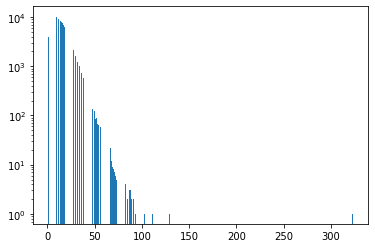

In [95]:
cellPhone_data_punct_json = pd.read_json('./cellPhone_data_punct.json')
cellPhone_data_punct_json = cellPhone_data_punct_json.T
cellPhone_data_punct_json

num_tokens = []
for i in cellPhone_data_punct_json.label.values:
    num_tokens.append(len(i))
print("NUMBER OF REVIEWS:", len(num_tokens))

import matplotlib.pyplot as plt
ax = plt.axes()
ax.set_yscale('log')
_ = plt.hist(num_tokens, bins='auto')

print("AVERAGE OF NUM_TOKENS:", np.mean(np.array(num_tokens)))

max_length = 0
for i in cellPhone_data_punct_json.label.values:
    new_length = len(i)
    if new_length > max_length:
        max_length = new_length
print("MAX_LENGTH:", max_length)

# **ASPECT EXTRACTION:**

**Improving BERT Performance for Aspect-based Sentiment Analysis:** [GitHub](https://github.com/IMPLabUniPr/BERT-for-ABSA/tree/H-SUM)  [Paper](https://arxiv.org/pdf/2010.11731.pdf)

**1. Go to this folder: BERT-for-ABSA**

```cd ./BERT-for-ABSA```

**2. Copy the file: cellPhone_data_punct.json from spacy tokenization folder to BERT-for-ABSA:**

```cp ./cellPhone_data_punct.json ./BERT-for-ABSA/ae/laptop/test.json```

**3. Run the aspect extraction script:**

```bash script/run_absa.sh ae laptop_pt laptop pt_ae 9 0```

In [96]:
def IOB_to_tokens(tags, tokens):
    aspects = []
    for idx , tag in enumerate(tags):
        if tag == "B":
            idx_B_start = idx + 1
            token_B_start = tokens[idx]
            for idx_ , tag_ in enumerate(tags[idx_B_start:]):
                if tag_ == "I":
                    idx_next = idx_B_start + idx_
                    token_next = tokens[idx_next]
                    token_B_start += " " + token_next
                if tag_ == "B" or tag_ == "O" or idx_next == len(tags) - 1:
                    aspects.append(str(token_B_start).replace("  ", " ").strip())
                    break
            if idx_B_start == len(tags):
                aspects.append(str(token_B_start).replace("  ", " ").strip())
        # E.g. tags = ['O', 'O', 'B', 'I', 'O', 'O', 'I', 'O']
        if tag == "I":
            if idx != 0:
                idx_I_before = idx - 1
                if tags[idx_I_before] == "O":
                    aspects.append(tokens[idx])
            else:
                aspects.append(tokens[0])
    return(aspects)

def list_string_to_string(list_string):
    review = ' '.join(list_string)
    review = review.replace(" ,", ",").replace(" '", "'").replace(" .", ".")
    review = review.replace(" !", "!").replace(" ?", "?").replace(" :", ":")
    review = review.replace(" n't", "n't").replace(" 'm", "'m")
    return(review)

In [102]:
path_to_predictions = "./GeneratedData/"
path = path_to_predictions + "predictions.json"

predictions_punct_df = pd.read_json(path)

predictions_punct_df['Index'] = punct_reviews_for_cellPhones.Index.values
predictions_punct_df['Length'] = predictions_punct_df.idx_map.apply(len)
predictions_punct_df.head()

,logits,raw_X,idx_map,Index,Length
0,"[[7.294774055480957, -4.487146854400635, -5.86...","[I, have, read, a, lot, of, the, reviews, and,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_0,21
1,"[[7.278045654296875, -4.461681365966797, -5.74...","[I, have, also, owned, and, used, Blackberries...","[0, 1, 2, 3, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10,...",B000FYU4SO_A10U3Z35FCPXF2_1,30
2,"[[7.205926418304443, -5.231839179992676, -5.27...","[I, picked, one, up, this, week, ,, and, here,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",B000FYU4SO_A10U3Z35FCPXF2_2,14
3,"[[6.856611251831055, -5.547577381134033, -4.49...","[The, phone, layout, and, design, are, excelle...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_3,18
4,"[[5.885629653930664, -6.081624984741211, -3.91...","[the, keys, are, in, a, much, better, location...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_4,33


Num_Reviews: 15
Max_length: 462


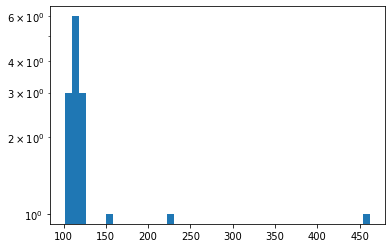

In [103]:
# Outliers
print("Num_Reviews:", len(predictions_punct_df[predictions_punct_df.Length > 100].Length.values))
print("Max_length:", max(predictions_punct_df[predictions_punct_df.Length > 100].Length.values))
ax = plt.axes()
ax.set_yscale('log')
_ = plt.hist(predictions_punct_df[predictions_punct_df.Length > 100].Length.values, bins='auto')

In [104]:
predictions_df_100 = predictions_punct_df[predictions_punct_df.Length < 100]
predictions_df_100 = predictions_df_100.reset_index(drop=True)

y_pred=[]
for ix, logit in enumerate(predictions_df_100["logits"]):
    pred=[0]*len(predictions_df_100["raw_X"][ix])
    #print(ix)
    for jx, idx in enumerate(predictions_df_100["idx_map"][ix]):
        #print(jx)
        lb=np.argmax(logit[jx])
        if lb==1: #B
            pred[idx]=1
        elif lb==2: #I
            if pred[idx]==0: #only when O->I (I->I and B->I ignored)
                pred[idx]=2
    y_pred.append(pred)

mapping = {0: "O", 1:"B", 2:"I"}
IOB_y_pred = []
for pred_list in y_pred:
    IOB_list = [mapping.get(item,item) for item in pred_list]
    IOB_y_pred.append(IOB_list)

predictions_df_100['tags'] = IOB_y_pred
predictions_df_100.head()

for i in range(1000):
    idx = i
    tags = predictions_df_100.tags.values[idx]
    tokens = predictions_df_100.raw_X.values[idx]
    _ = IOB_to_tokens(tags, tokens)

,logits,raw_X,idx_map,Index,Length,tags
0,"[[7.294774055480957, -4.487146854400635, -5.86...","[I, have, read, a, lot, of, the, reviews, and,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_0,21,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[[7.278045654296875, -4.461681365966797, -5.74...","[I, have, also, owned, and, used, Blackberries...","[0, 1, 2, 3, 4, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10,...",B000FYU4SO_A10U3Z35FCPXF2_1,30,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[[7.205926418304443, -5.231839179992676, -5.27...","[I, picked, one, up, this, week, ,, and, here,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",B000FYU4SO_A10U3Z35FCPXF2_2,14,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,"[[6.856611251831055, -5.547577381134033, -4.49...","[The, phone, layout, and, design, are, excelle...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_3,18,"[O, B, I, O, B, O, O, O, O, O, O, O, O, O, O, ..."
4,"[[5.885629653930664, -6.081624984741211, -3.91...","[the, keys, are, in, a, much, better, location...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",B000FYU4SO_A10U3Z35FCPXF2_4,33,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [105]:
punct_aspect_df = pd.DataFrame()
punct_aspect_df['Index'] = predictions_df_100.Index.values

# convert list of strings to string
punct_aspect_df['Review'] = predictions_df_100.raw_X.apply(list_string_to_string).values

# convert tags to tokens
punct_aspect_df['Aspect'] = predictions_df_100.apply(lambda x: IOB_to_tokens(x.tags, x.raw_X), axis=1).values

punct_aspect_df.to_json("./punct_aspect_df.json")

In [106]:
punct_aspect_json_df = pd.read_json("./punct_aspect_df.json")
punct_aspect_json_df

,Index,Review,Aspect
0,B000FYU4SO_A10U3Z35FCPXF2_0,I have read a lot of the reviews and spoken to...,[]
1,B000FYU4SO_A10U3Z35FCPXF2_1,I have also owned and used Blackberries Treo's...,[]
2,B000FYU4SO_A10U3Z35FCPXF2_2,"I picked one up this week, and here are my ini...",[]
3,B000FYU4SO_A10U3Z35FCPXF2_3,The phone layout and design are excellent Comp...,"[phone layout, design]"
4,B000FYU4SO_A10U3Z35FCPXF2_4,"the keys are in a much better location, ( abou...",[keys]
...,...,...,...
200084,B01H93TCCM_A28EUF394DMX8_3,"but besides that, the phone works fantastic.",[works]
200085,B01H93TCCM_A28EUF394DMX8_4,"and one little scratch on the screen, but have...",[screen]
200086,B01HDJYD5S_AH87KTZDV5R26_0,Nice phone.,[]
200087,B01HDJYD5S_AH87KTZDV5R26_1,"looks like new, but did not come in a Samsung ...",[]


# **ASPECT-BASED SENTIMENT ANALYSIS:**

**LCF: A Local Context Focus Mechanism for Aspect-Based Sentiment Classification:** [GitHub](https://github.com/songyouwei/ABSA-PyTorch)  [Paper](https://www.proquest.com/openview/a1a719bc40fffafe8c7546382a4a4d68/1?pq-origsite=gscholar&cbl=2032433)

**1. Go to this folder: ABSA-PyTorch**

```cd ./ABSA-PyTorch```

**2. Run the aspect-based sentiment analysis script:**

```python3 absa.py```

In [13]:
punct_aspect_sentiment_json_df = pd.read_json("./punct_aspect_sentiment_df.json")
punct_aspect_sentiment_json_df

,Index,Review,Aspect,Polarity,Polarity_score
0,B000FYU4SO_A10U3Z35FCPXF2_0,I have read a lot of the reviews and spoken to...,[],[[]],[[]]
1,B000FYU4SO_A10U3Z35FCPXF2_1,I have also owned and used Blackberries Treo's...,[],[[]],[[]]
2,B000FYU4SO_A10U3Z35FCPXF2_2,"I picked one up this week, and here are my ini...",[],[[]],[[]]
3,B000FYU4SO_A10U3Z35FCPXF2_3,The phone layout and design are excellent Comp...,"[phone layout, design]","[[2], [2]]","[[[0.0006168717, 0.0041612685, 0.9952217937000..."
4,B000FYU4SO_A10U3Z35FCPXF2_4,"the keys are in a much better location, ( abou...",[keys],[[2]],"[[[0.0489408784, 0.1182436198, 0.8328155875000..."
...,...,...,...,...,...
200084,B01H93TCCM_A28EUF394DMX8_3,"but besides that, the phone works fantastic.",[works],[[2]],"[[[0.006038983800000001, 0.0247149374, 0.96924..."
200085,B01H93TCCM_A28EUF394DMX8_4,"and one little scratch on the screen, but have...",[screen],[[1]],"[[[0.397775352, 0.5148792267, 0.0873454735]]]"
200086,B01HDJYD5S_AH87KTZDV5R26_0,Nice phone.,[],[[]],[[]]
200087,B01HDJYD5S_AH87KTZDV5R26_1,"looks like new, but did not come in a Samsung ...",[],[[]],[[]]


In [15]:
all_extracted_aspects = []
for idx, row in punct_aspect_sentiment_json_df.iterrows():
    aspect_list = row['Aspect']
    for aspect in aspect_list:
        all_extracted_aspects.append(str(aspect).lower())
all_extracted_aspects[:10]

with open('./Cellphone_all_extracted_aspects.pkl', 'wb') as fp:
    pickle.dump(all_extracted_aspects, fp, protocol=4)

['phone layout',
 'design',
 'keys',
 'keys functions',
 'active sync',
 'setup',
 'start',
 'syncing',
 'outlook',
 'internet connections']

<Figure size 1080x576 with 0 Axes>

(-0.5, 999.5, 499.5, -0.5)

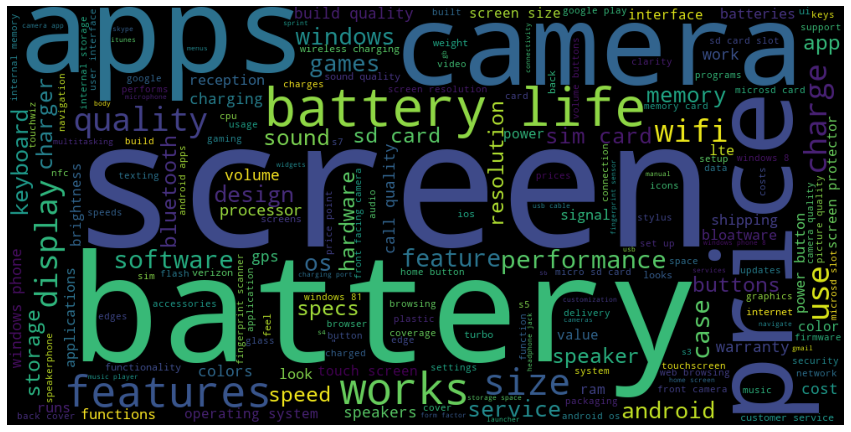

In [16]:
from collections import Counter
from wordcloud import WordCloud
word_could_dict=Counter(all_extracted_aspects)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
aspect_frequency_sorted = {k: v for k, v in sorted(dict(word_could_dict).items(), key=lambda item: item[1], reverse=True)}
aspect_frequency_df = pd.DataFrame()
aspect_frequency_df["Aspect"] = list(aspect_frequency_sorted.keys())
aspect_frequency_df["Frequency"] = list(aspect_frequency_sorted.values())
print("Number of extracted aspects:", aspect_frequency_df.shape[0])
aspect_100 = aspect_frequency_df[aspect_frequency_df.Frequency > 99]
aspect_100

Number of extracted aspects: 22281


,Aspect,Frequency
0,screen,5823
1,battery,4751
2,apps,4425
3,camera,3985
4,price,3760
...,...,...
155,updates,103
156,volume buttons,102
157,windows 81,101
158,edge,100


In [18]:
aspect_100.Aspect.values
len(aspect_100.Aspect.values)
len(list(aspect_frequency_df[aspect_frequency_df.Frequency == 1].Aspect.values))
list(aspect_frequency_df[aspect_frequency_df.Frequency == 1].Aspect.values)[:10]

array(['screen', 'battery', 'apps', 'camera', 'price', 'battery life',
       'works', 'features', 'size', 'quality', 'use', 'display', 'charge',
       'wifi', 'performance', 'software', 'case', 'feature', 'games',
       'windows', 'os', 'android', 'design', 'service', 'keyboard',
       'sound', 'sim card', 'charger', 'memory', 'app', 'sd card',
       'hardware', 'speaker', 'storage', 'bluetooth', 'speed', 'buttons',
       'specs', 'resolution', 'processor', 'volume', 'speakers',
       'warranty', 'colors', 'cost', 'work', 'gps', 'charging',
       'call quality', 'build quality', 'windows phone', 'runs',
       'reception', 'shipping', 'bloatware', 'signal', 'lte',
       'power button', 'look', 'applications', 'functions', 'batteries',
       'operating system', 'value', 'screen size', 'ram',
       'screen protector', 'color', 'touch screen', 'interface', 'power',
       'brightness', 'sound quality', 'feel', 'functionality', 'ios',
       'looks', 'ui', 'internet', 'wireless 

160

15450

['phone layout',
 'keys functions',
 'internet connections',
 'quality assurance program',
 'verizonwireless services',
 'ms office multimedia',
 'talk quality',
 'mail server',
 'verizonwireless pricing',
 'broadband modem']

In [19]:
def filter_aspects(row_aspect):
    valids = re.sub(r"[^A-Za-z]+", '', row_aspect)
    
    correct_aspects = ["usb", "cpu", "app", "ram", "gps", "sim", "ui", "ios", "run", "pen", "lte", "ios",
                       "mic", "sd", "os", "ask", "use", "gpu", "key", "fee", "cam", "pad", "nfc",
                       "gui", "vpn", "pay", "pic", "map", "fan", "set", "win", "buy", "tpu", "mp3", "web"]
    
    if len(valids) > 3 or valids in correct_aspects:
        return(True)
    else:
        return(False)

In [20]:
filtered_aspects = aspect_frequency_df.Aspect.apply(filter_aspects)
wrong_aspects_3 = list(aspect_frequency_df[~filtered_aspects].Aspect.values)

with open('./wrong_aspects_3.pkl', 'wb') as fp:
    pickle.dump(wrong_aspects_3, fp, protocol=4)

In [21]:
similar_aspect_list = [['android', 'android os'],
                       ['app', 'applications', 'apps', 'android apps'],
                       ['battery', 'battery life', 'batteries'],
                       ['build', 'build quality', 'built'],
                       ['button', 'buttons'],
                       ['camera', 'camera quality'],
                       ['charge', 'charger', 'charges', 'charging'],
                       ['color', 'colors'],
                       ['cost', 'costs'],
                       ['edge', 'edges'],
                       ['feature', 'features'],
                       ['front camera', 'front facing camera'],
                       ['function', 'functionality', 'functions'],
                       ['games', 'gaming'],
                       ['internal memory', 'internal storage'],
                       ['keyboard', 'keys'],
                       ['memory', 'memory card'],
                       ['operating system', 'os',],
                       ['performance', 'performs'],
                       ['power', 'power button'],
                       ['price', 'price point', 'prices'],
                       ['screen', 'screens'],
                       ['micro sd card', 'microsd card', 'sd card', 'microsd slot'],
                       ['set up', 'setup'],
                       ['sim', 'sim card'],
                       ['sound', 'sound quality'],
                       ['speaker', 'speakerphone', 'speakers'],
                       ['speed', 'speeds'],
                       ['touch screen', 'touchscreen'],
                       ['ui', 'user interface']]

In [22]:
aspect_filtered_100 = aspect_frequency_df[filtered_aspects][aspect_frequency_df[filtered_aspects].Frequency > 99]
aspect_filtered_100_list = list(aspect_filtered_100[aspect_filtered_100.Frequency > 99].Aspect.values)

In [23]:
len(aspect_filtered_100_list)

157

In [24]:
special_aspect = ['look', 'looks', 'google', 'runs', 'use', 'work', 'works']
wrong_aspects = wrong_aspects_3 + ["lumia 1020", "zero key", "verizon", 'back', 'edge', 'feel', 'phone', 'seller']
final_aspect_100_list = [aspect for aspect in aspect_filtered_100_list if aspect not in wrong_aspects]

In [25]:
sentiments = {0: 'Negative', 1: "Neutral", 2: 'Positive', -999: ''}
def sentiment_aspect_dict(index, review, aspect_list, polarity_list, 
                          polarity_score_list, sentiments, final_aspect_100_list, polarity_treshold = 0.8):
    absa_dictionary = {}    
    if aspect_list:
        for counter, aspect in enumerate(aspect_list):
            if aspect in final_aspect_100_list:
                polarity_scores = polarity_score_list[counter][0]
                if max(polarity_scores) >= polarity_treshold:
                    new_index = str(index) + "_" + str(counter)
                    absa_dictionary[(new_index, aspect)] = {}
                    absa_dictionary[(new_index, aspect)]['review'] = review
                    polarity_idx = polarity_list[counter][0]
                    absa_dictionary[(new_index, aspect)]['polarity'] = sentiments[polarity_idx]
                    polarity_scores = polarity_score_list[counter][0]
                    absa_dictionary[(new_index, aspect)]['polarity_scores'] = polarity_scores
    return(absa_dictionary)

sentiment_aspect_dict_all = {}
for idx, row in punct_aspect_sentiment_json_df.iterrows():
    if idx%1000 == 0:
        print(idx)
    all_index_list = row['Index'].split("_")
    item = str(all_index_list[0])
    
    index = row['Index'] 
    review = row['Review']
    aspect_list = row['Aspect']
    polarity_list = row['Polarity']
    polarity_score_list = row['Polarity_score']
    
    absa_dict_result = sentiment_aspect_dict(index, review, aspect_list, polarity_list, 
                                             polarity_score_list, sentiments, final_aspect_100_list, polarity_treshold = 0.8)
    if absa_dict_result:
        if item not in sentiment_aspect_dict_all:
            sentiment_aspect_dict_all[item] = []
            sentiment_aspect_dict_list = sentiment_aspect_dict_all[item]
            sentiment_aspect_dict_list.append(absa_dict_result)
        else:
            sentiment_aspect_dict_list = sentiment_aspect_dict_all[item]
            sentiment_aspect_dict_list.append(absa_dict_result)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [27]:
with open('./Cellphone_similar_aspect_list_100.pkl', 'wb') as fp:
    pickle.dump(similar_aspect_list, fp, protocol=4)
    
with open('./Cellphone_sentiment_aspect_dict_100.pkl', 'wb') as fp:
    pickle.dump(sentiment_aspect_dict_all, fp, protocol=4)

# **GENERATING QA & OP PAIRS:**

In [28]:
english_vocab = pd.read_pickle("./english_vocab.pkl")
stop_words = pd.read_pickle("./stop_words.pkl")
wrong_aspects_3 = pd.read_pickle('./wrong_aspects_3.pkl')
metaData_for_cellPhones = pd.read_pickle("./metaData_for_cellPhones.pkl")
dict_AspectSentiment = pd.read_pickle('./Cellphone_sentiment_aspect_dict_100.pkl')

with open(".../Data/GeneratedData/retrieved_items_dict.json") as f:
    retrieved_items_dict = json.load(f)

wrong_aspects = wrong_aspects_3 + ["lumia 1020", "zero key", "verizon", 'back', 'edge', 'feel', 'phone', 'seller']

correct_forms = ['bluetooth']

Q1A_list = ["What do you think about its {}?", "May I know your opinion on its {}?",
            "What about its {}?", "Do you have any views on its {}?",
            "Could you tell me your opinion on its {}?",
            "Do you have any opinions about its {}?", "In your honest opinion, how is its {}?",
            "Can you give me your thoughts on its {}?", "I’d like to know your views on its {}.",
            "Do you have any particular views on its {}?", "From your point of view, how is the {}?",
            "I’d be very interested to know your views on its {}."
           ]

Oneg1A_list = ["I heard about its {} that ",
               "I was told by one of my friends about its {} that ",
               "As far as I know about its {}, ",
               "What I know about its {} is that "]

Opos1A_list = ["No, I don't think so, because ",
               "Let me disagree with you, because ",
               "I see your point, but ",
               "I see what you mean, but "]

# For MultiWOZ
#Opos1B_list = ["If {} is important for you, we can offer this item. ", 
#               "If {} is a crucial feature for you, we have this item. "]

Opos1B_list = ["If {} is important for you, we can offer this item: {} ", 
               "If {} is a crucial feature for you, we have this item: {} "]

Opos2A_list = ["I can see what you’re saying but I disagree with you on its {} and even I can tell you something interesting about this phone and its {} that ",
               "I’m sorry but I don’t think so, specially about its {} and I would mention something about the {} of this phone that "]

# For MultiWOZ
#Opos1B1_list = ["I heard about this phone and specially its {} that ",
#               "I was told by one of my friends about this phone and its {} that ",
#               "I was wondering if you have this phone, it might be a good choice because as far as I know about its {}, "]

Opos1B1_list = ["I heard about this phone {} and specially its {} that ",
                "I was told by one of my friends about this phone {} and its {} that ",
                "I was wondering if you have this phone {}, it might be a good choice because as far as I know about its {}, "]

Opos1B2_list = ["Yes, it's true! This phone is also a good choice.",
                "Yes, That's so true. This phone is also a good choice.",
                "Yes, That's for sure. This phone is also a good choice.",
                "Yes, I think so too. This phone is also a good choice.",
                "Yes, That is what I think too. This phone is also a good choice.",
                "Yes! I agree with you. This phone is also a good choice.",
                "Yes, I agree with you about it. This phone is also a good choice.",
                "Yes, That's exactly what I know about it. This phone is also a good choice."]

Opos2B_list = ["Yes, it's true! This phone is also a good choice and even I can tell you something interesting about this phone and its {} that ",
               "Yes, That's so true. This phone is also a good choice and I would mention something about the {} of this phone that ",
               "Yes, That's for sure. This phone is also a good choice and even I can tell you something interesting about this phone and its {} that ",
               "Yes, I think so too. This phone is also a good choice and I would mention something about the {} of this phone that ",
               "Yes, That is what I think too. This phone is also a good choice and even I can tell you something interesting about this phone and its {} that ",
               "Yes! I agree with you. This phone is also a good choice and I would mention something about the {} of this phone that ",
               "Yes, I agree with you about it. This phone is also a good choice and even I can tell you something interesting about this phone and its {} that ",
               "Yes, That's exactly what I know about it. This phone is also a good choice and I would mention something about the {} of this phone that "]

Oneg2B_list = ["Yes, it's true! This phone might be a good choice but you should know about its {} that ",
               "Yes, That's so true. This phone can be also a good choice but I should say about the {} of this phone that ",
               "Yes, That's for sure. This phone is also a good choice However about the {} of this phone I should say that ",
               "Yes, I completely agree with you. This phone might be a good choice but you should know about its {} that ",
               "Yes, I totally agree with you. This phone can be also a good choice but I should say about the {} of this phone that ",
               "Yes! I agree with you. This phone is also a good choice However about the {} of this phone I should say that ",
               "Yes, I agree with you about it. This phone can be also a good choice but I should say about the {} of this phone that ",
               "Yes, That's exactly what I know about it. However I should say something about the {} of this phone that "]

In [29]:
def aspects_similarity_check(aspect_1, aspect_2, similar_aspect_list):
    check=False
    for i in similar_aspect_list:
        if aspect_1.lower() in i and aspect_2.lower() in i:
            check=True
            break
    if check:
        return(True)
    else:
        return(False)

def cleaning_aspect(aspect):
    if aspect != None:
        cleaned_aspect = aspect.replace("/", "")
        cleaned_aspect = re.sub(' +', ' ', cleaned_aspect)
        cleaned_aspect = cleaned_aspect.strip()
    else:
        cleaned_aspect = aspect
    return(cleaned_aspect)

def cleaning_review(review):
    if str(review).lower()[:3].strip() == "but":
        cleaned_review = str(review)[3:].strip(":")
        cleaned_review = cleaned_review.strip(";")
        cleaned_review = cleaned_review.strip(",")
        cleaned_review = cleaned_review.strip()
    elif str(review).lower()[:3].strip() == "and":
        cleaned_review = str(review)[3:].strip(":")
        cleaned_review = cleaned_review.strip(";")
        cleaned_review = cleaned_review.strip(",")
        cleaned_review = cleaned_review.strip()
    elif str(review).lower()[:4].strip() == "then":
        cleaned_review = str(review)[4:].strip(":")
        cleaned_review = cleaned_review.strip(";")
        cleaned_review = cleaned_review.strip(",")
        cleaned_review = cleaned_review.strip()
    elif str(review).lower()[:9].strip() == "otherwise":
        cleaned_review = str(review)[9:].strip(":")
        cleaned_review = cleaned_review.strip(";")
        cleaned_review = cleaned_review.strip(",")
        cleaned_review = cleaned_review.strip()
    else:
        cleaned_review = review
    return(cleaned_review)

In [4]:
metaData_for_cellPhones = pd.read_pickle("./metaData_for_cellPhones.pkl")

In [52]:
def Qpos1A_Apos1A(item, wrong_aspects, correct_forms, Q11_list, dict_AspectSentiment):
    blocks = {}
    counter = 0
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'positive':
                        counter += 1
                        aspect = cleaning_aspect(str(aspect))
                        
                        Qpos1A = random.choice(Q1A_list).format(aspect)
                        Apos1A = review
                        
                        blocks["Qpos1A_Apos1A_" + str(counter)] = {}
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A'] = {}
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A']['Question'] = Qpos1A
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A']['Labels'] = {}
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A']['Labels']['Key'] = key
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A']['Labels']['Aspect'] = aspect
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Qpos1A']['Labels']['Polarity'] = str(polarity).lower()
                        
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A'] = {}
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A']['Answer'] = Apos1A
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A']['Labels'] = {}
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A']['Labels']['Key'] = key
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A']['Labels']['Aspect'] = aspect
                        blocks["Qpos1A_Apos1A_" + str(counter)]['Apos1A']['Labels']['Polarity'] = str(polarity).lower()
    return(blocks)

def Oneg1A_Opos1A(item, wrong_aspects, correct_forms, Oneg1A_list, Opos1A_list, dict_AspectSentiment):
    blocks = {}
    counter = 0
    similarity = 0
    aspect_review_polarity_key_list = []
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'positive':
                        aspect_review_polarity_key_list.append((aspect, review, polarity, key))

        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect != None and aspect not in wrong_aspects:
                    if str(polarity).lower() == 'negative':
                        sentence_aspect = review
                        
                        Oneg1A = random.choice(Oneg1A_list).format(aspect) + sentence_aspect
                        
                        for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                            aspect_ = cleaning_aspect(aspect_)
                                
                            if str(polarity_).lower() == 'positive' and np.logical_or(str(aspect) == str(aspect_), aspects_similarity_check(aspect, aspect_, similar_aspect_list)):
                                counter += 1
                                sentence_aspect_ = review_

                                Opos1A = random.choice(Opos1A_list) + sentence_aspect_

                                blocks["Oneg1A_Opos1A_" + str(counter)] = {}
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A'] = {}
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A']['Opinion'] = Oneg1A
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A']['Labels'] = {}
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A']['Labels']['Key'] = key
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A']['Labels']['Aspect'] = aspect
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Oneg1A']['Labels']['Polarity'] = str(polarity).lower()

                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A'] = {}
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A']['Opinion'] = Opos1A
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A']['Labels'] = {}
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A']['Labels']['Key'] = key_
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A']['Labels']['Aspect'] = aspect_
                                blocks["Oneg1A_Opos1A_" + str(counter)]['Opos1A']['Labels']['Polarity'] = str(polarity_).lower()
    return(blocks)

def Oneg1A_Opos1B(item, retrieved_items, wrong_aspects, correct_forms, Oneg1A_list, Opos1B_list, dict_AspectSentiment, DF, retrieved=True, also_view=False):
    blocks = {}
    counter = 0
    similarity = 0
    item_1 = item
    if retrieved:
        other_items_list = [i for i in retrieved_items if i != item_1]
    elif also_view:
        if DF.query("asin == @item_1").also_view.values.size > 0:
            other_items_list = DF.query("asin == @item_1").also_view.values[0]
        else:
            other_items_list = None
    if other_items_list:
        aspect_review_polarity_key_lists = []
        for item_2 in other_items_list:
            item_2_review_list = dict_AspectSentiment.get(item_2)
            if item_2_review_list:
                aspect_review_polarity_key_list = []
                for item_2_review_dict in item_2_review_list:
                    for item_2_reviewer_aspect_key, item_2_review_sentiment in (item_2_review_dict.items()):
                        item_2_key = item_2_reviewer_aspect_key[0]
                        item_2_aspect = item_2_reviewer_aspect_key[1]
                        item_2_aspect = cleaning_aspect(item_2_aspect)
                        item_2_review = item_2_review_sentiment['review']
                        item_2_review = cleaning_review(item_2_review)
                        item_2_polarity = item_2_review_sentiment['polarity']
                        if item_2_aspect not in wrong_aspects and item_2_aspect != None:
                            if str(item_2_polarity).lower() == 'positive':
                                aspect_review_polarity_key_list.append((item_2, item_2_aspect, item_2_review, item_2_polarity, item_2_key))

                aspect_review_polarity_key_lists.append(aspect_review_polarity_key_list)


        item_1_review_list = dict_AspectSentiment.get(item_1)
        if item_1_review_list:
            for item_1_review_dict in item_1_review_list:
                for item_1_reviewer_aspect_key, item_1_review_sentiment in (item_1_review_dict.items()):
                    item_1_key = item_1_reviewer_aspect_key[0]
                    item_1_aspect = item_1_reviewer_aspect_key[1]
                    item_1_aspect = cleaning_aspect(item_1_aspect)
                    item_1_review = item_1_review_sentiment['review']
                    item_1_review = cleaning_review(item_1_review)
                    item_1_polarity = item_1_review_sentiment['polarity']
                    if item_1_aspect != None and item_1_aspect not in wrong_aspects:
                        if str(item_1_polarity).lower() == 'negative':
                            Oneg1A = random.choice(Oneg1A_list).format(item_1_aspect) + item_1_review

                            for item_aspect_review_polarity_key in aspect_review_polarity_key_lists:
                                for item_, aspect_, review_, polarity_, key_ in item_aspect_review_polarity_key:
                                    aspect_ = cleaning_aspect(aspect_)

                                    if str(polarity_).lower() == 'positive' and np.logical_or(str(item_1_aspect) == str(aspect_), aspects_similarity_check(item_1_aspect, aspect_, similar_aspect_list)):
                                        counter += 1
                                        
                                        
                                        Opos1B = random.choice(Opos1B_list).format(item_1_aspect, item_) + review_
                                        #For MultiWOZ
                                        #Opos1B = random.choice(Opos1B_list).format(item_1_aspect) + review_

                                        blocks["Oneg1A_Opos1B_" + str(counter)] = {}
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A'] = {}
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A']['Opinion'] = Oneg1A
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A']['Labels'] = {}
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A']['Labels']['Key'] = item_1_key
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A']['Labels']['Aspect'] = item_1_aspect
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Oneg1A']['Labels']['Polarity'] = str(item_1_polarity).lower()

                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B'] = {}
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B']['Opinion'] = Opos1B
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B']['Labels'] = {}
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B']['Labels']['Key'] = key_
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B']['Labels']['Aspect'] = aspect_
                                        blocks["Oneg1A_Opos1B_" + str(counter)]['Opos1B']['Labels']['Polarity'] = str(polarity_).lower()
                                    
    return(blocks)

def Oneg1A_Opos2A(item, wrong_aspects, correct_forms, Oneg1A_list, Opos2A_list, dict_AspectSentiment, restricted_version=True):
    blocks = {}
    counter = 0
    similarity = 0
    aspect_review_polarity_key_list = []
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'positive':
                        aspect_review_polarity_key_list.append((aspect, review, polarity, key))

        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect != None and aspect not in wrong_aspects:
                    if str(polarity).lower() == 'negative':
                        
                        Oneg1A = random.choice(Oneg1A_list).format(aspect) + review
                        
                        check = False 
                        # We disagree with the user only when there is a positive review for the aspect, mentioned by user
                        if restricted_version == True:
                            for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                                if check == False:
                                    aspect_ = cleaning_aspect(aspect_)

                                    if str(polarity_).lower() == 'positive' and np.logical_or(str(aspect) == str(aspect_), aspects_similarity_check(aspect, aspect_, similar_aspect_list)):
                                        check = True
                                        break
                            
                            if check == True:
                                for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                                    aspect_ = cleaning_aspect(aspect_)
                                    if str(polarity_).lower() == 'positive':
                                        counter += 1

                                        Opos2A = random.choice(Opos2A_list).format(aspect, aspect_) + review_

                                        blocks["Oneg1A_Opos2A_" + str(counter)] = {}
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A'] = {}
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Opinion'] = Oneg1A
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels'] = {}
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Key'] = key
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Aspect'] = aspect
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Polarity'] = str(polarity).lower()

                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A'] = {}
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Opinion'] = Opos2A
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels'] = {}
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Key'] = key_
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Aspect'] = aspect_
                                        blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Polarity'] = str(polarity_).lower()
                        
                        else:
                            for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                                aspect_ = cleaning_aspect(aspect_)
                                if str(polarity_).lower() == 'positive':
                                    counter += 1

                                    Opos2A = random.choice(Opos2A_list).format(aspect, aspect_) + review_

                                    blocks["Oneg1A_Opos2A_" + str(counter)] = {}
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A'] = {}
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Opinion'] = Oneg1A
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels'] = {}
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Key'] = key
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Aspect'] = aspect
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Oneg1A']['Labels']['Polarity'] = str(polarity).lower()

                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A'] = {}
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Opinion'] = Opos2A
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels'] = {}
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Key'] = key_
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Aspect'] = aspect_
                                    blocks["Oneg1A_Opos2A_" + str(counter)]['Opos2A']['Labels']['Polarity'] = str(polarity_).lower()
                                    
    return(blocks)


done_items_neg = []
all_blocks_neg = {}

for index in list(retrieved_items_dict.keys()):
    print(str(index))
    retrieved_items_1 = retrieved_items_dict[str(index)].get("retrieved items")
    retrieved_items_with_review = [i for i in retrieved_items_1 if metaData_for_cellPhones.query("asin == @i").num_reviews.values[0] > 0]
    print('retrieved_items_with_review:', retrieved_items_with_review)
    if len(retrieved_items_with_review) > 0:
        for item in retrieved_items_with_review:
            if item not in done_items_neg:
                done_items_neg.append(item)
                print(item)
                all_blocks_neg[str(item)] = {}
                blocks_Qpos1A_Apos1A = Qpos1A_Apos1A(item, wrong_aspects, correct_forms, Q1A_list, dict_AspectSentiment)
                all_blocks_neg[str(item)]['Qpos1A_Apos1A'] = blocks_Qpos1A_Apos1A
                print("blocks_Qpos1A_Apos1A is DONE!")
                
                blocks_Oneg1A_Opos1A = Oneg1A_Opos1A(item, wrong_aspects, correct_forms, Oneg1A_list, Opos1A_list, dict_AspectSentiment)
                all_blocks_neg[str(item)]['Oneg1A_Opos1A'] = blocks_Oneg1A_Opos1A
                print("blocks_Oneg1A_Opos1A is DONE!")

                blocks_Oneg1A_Opos1B_retrieved = Oneg1A_Opos1B(item, retrieved_items_with_review, wrong_aspects, correct_forms, Oneg1A_list, Opos1B_list,
                                                     dict_AspectSentiment, metaData_for_cellPhones, retrieved=True, also_view=False)
                all_blocks_neg[str(item)]['Oneg1A_Opos1B_retrieved'] = blocks_Oneg1A_Opos1B_retrieved
                print("blocks_Oneg1A_Opos1B_retrieved is DONE!")

                blocks_Oneg1A_Opos1B_also_view = Oneg1A_Opos1B(item, retrieved_items_with_review, wrong_aspects, correct_forms, Oneg1A_list, Opos1B_list,
                                                     dict_AspectSentiment, metaData_for_cellPhones, retrieved=False, also_view=True)
                all_blocks_neg[str(item)]['Oneg1A_Opos1B_also_view'] = blocks_Oneg1A_Opos1B_also_view
                print("blocks_Oneg1A_Opos1B_also_view is DONE!")

                blocks_Oneg1A_Opos2A_restricted = Oneg1A_Opos2A(item, wrong_aspects, correct_forms, Oneg1A_list, Opos2A_list,
                                                    dict_AspectSentiment, restricted_version=True)
                all_blocks_neg[str(item)]['Oneg1A_Opos2A_restricted'] = blocks_Oneg1A_Opos2A_restricted
                print("blocks_Oneg1A_Opos2A_restricted is DONE!")
                
                blocks_Oneg1A_Opos2A_unrestricted = Oneg1A_Opos2A(item, wrong_aspects, correct_forms, Oneg1A_list, Opos2A_list,
                                                                  dict_AspectSentiment, restricted_version=False)
                all_blocks_neg[str(item)]['Oneg1A_Opos2A_unrestricted'] = blocks_Oneg1A_Opos2A_unrestricted
                print("blocks_Oneg1A_Opos2A_unrestricted is DONE!")

with open('./100_blocks_neg.json', 'w') as f:
    json.dump(all_blocks_neg, f)

with open('./done_items_neg.pkl', 'wb') as fp:
    pickle.dump(done_items_neg, fp, protocol=4)

1
retrieved_items_with_review: []
2
retrieved_items_with_review: []
3
retrieved_items_with_review: []
4
retrieved_items_with_review: []
5
retrieved_items_with_review: []
6
retrieved_items_with_review: []
7
retrieved_items_with_review: []
8
retrieved_items_with_review: []
9
retrieved_items_with_review: ['B00J9XQRFG']
B00J9XQRFG
blocks_Qpos1A_Apos1A is DONE!
blocks_Oneg1A_Opos1A is DONE!
blocks_Oneg1A_Opos1B_retrieved is DONE!
blocks_Oneg1A_Opos1B_also_view is DONE!
blocks_Oneg1A_Opos2A_restricted is DONE!
blocks_Oneg1A_Opos2A_unrestricted is DONE!
10
retrieved_items_with_review: []
11
retrieved_items_with_review: []
12
retrieved_items_with_review: ['B00J9XQRFG']
13
retrieved_items_with_review: []
14
retrieved_items_with_review: []
15
retrieved_items_with_review: []
16
retrieved_items_with_review: []
17
retrieved_items_with_review: []
18
retrieved_items_with_review: []
19
retrieved_items_with_review: []
20
retrieved_items_with_review: []
21
retrieved_items_with_review: ['B00836Y6B2']
B00

In [31]:
def Opos1B_Opos2B(item, wrong_aspects, correct_forms, Opos1B1_list, Opos2B_list, dict_AspectSentiment):
    blocks = {}
    counter = 0
    similarity = 0
    aspect_review_polarity_key_list = []
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'positive':
                        aspect_review_polarity_key_list.append((aspect, review, polarity, key))
                        
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect != None and aspect not in wrong_aspects:
                    if str(polarity).lower() == 'positive':
                        
                        sentence_aspect = review
                        
                        #For MultiWOZ
                        #Opos1B = random.choice(Opos1B1_list).format(aspect) + sentence_aspect
                        Opos1B = random.choice(Opos1B1_list).format(item, aspect) + sentence_aspect
    
                        for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                            aspect_ = cleaning_aspect(aspect_)
                            if str(polarity_).lower() == 'positive' and str(review) != str(review_):
                                counter += 1

                                sentence_aspect_ = review_

                                Opos2B = random.choice(Opos2B_list).format(aspect_) + sentence_aspect_

                                blocks["Opos1B_Opos2B_" + str(counter)] = {}
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B'] = {}
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B']['Opinion'] = Opos1B
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B']['Labels'] = {}
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B']['Labels']['Key'] = key
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B']['Labels']['Aspect'] = aspect
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos1B']['Labels']['Polarity'] = str(polarity).lower()

                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B'] = {}
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B']['Opinion'] = Opos2B
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B']['Labels'] = {}
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B']['Labels']['Key'] = key_
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B']['Labels']['Aspect'] = aspect_
                                blocks["Opos1B_Opos2B_" + str(counter)]['Opos2B']['Labels']['Polarity'] = str(polarity_).lower()
    return(blocks)

def Opos1B_Opos1B2(item, wrong_aspects, correct_forms, Opos1B1_list, Opos1B2_list,
                  dict_AspectSentiment, only_agreement=True, agreement_and_more=True):
    blocks = {}
    counter = 0
    similarity = 0
    aspect_review_polarity_key_list = []
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list and agreement_and_more:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'positive':
                        aspect_review_polarity_key_list.append((aspect, review, polarity, key))
                        
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect != None and aspect not in wrong_aspects:
                    if str(polarity).lower() == 'positive':
                        
                        #For MultiWOZ
                        #Opos1B = random.choice(Opos1B1_list).format(aspect) + sentence_aspect
                        Opos1B = random.choice(Opos1B1_list).format(item, aspect) + review
                        
                        if only_agreement:
                            counter += 1
                            
                            Opos1B2 = random.choice(Opos1B2_list)
                            
                            blocks["Opos1B_Opos1B2_" + str(counter)] = {}
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B'] = {}
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Opinion'] = Opos1B
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels'] = {}
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Key'] = key
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Aspect'] = aspect
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Polarity'] = str(polarity).lower()

                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2'] = {}
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Opinion'] = Opos1B2
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels'] = {}
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Key'] = key
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Aspect'] = aspect
                            blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Polarity'] = str(polarity).lower()
                            
                        elif agreement_and_more:
                            
                            for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                                aspect_ = cleaning_aspect(aspect_)

                                if np.logical_or(aspect == aspect_, aspects_similarity_check(aspect, aspect_, similar_aspect_list)) and str(review_) != str(review):  
                                    counter += 1

                                    Opos1B2 = random.choice(Opos1B2_list) + " " + review_

                                    blocks["Opos1B_Opos1B2_" + str(counter)] = {}
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B'] = {}
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Opinion'] = Opos1B
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels'] = {}
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Key'] = key
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Aspect'] = aspect
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B']['Labels']['Polarity'] = str(polarity).lower()

                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2'] = {}
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Opinion'] = Opos1B2
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels'] = {}
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Key'] = key_
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Aspect'] = aspect_
                                    blocks["Opos1B_Opos1B2_" + str(counter)]['Opos1B2']['Labels']['Polarity'] = str(polarity_).lower()
    return(blocks)

def Opos1B_Oneg2B(item, wrong_aspects, correct_forms, Opos1B1_list, Oneg2B_list, dict_AspectSentiment):
    blocks = {}
    counter = 0
    similarity = 0
    aspect_review_polarity_key_list = []
    item_review_list = dict_AspectSentiment.get(item)
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect not in wrong_aspects and aspect != None:
                    if str(polarity).lower() == 'negative':
                        aspect_review_polarity_key_list.append((aspect, review, polarity, key))
                        
    if item_review_list:
        for review_dict in item_review_list:
            for item_reviewer_aspect_key, review_sentiment in (review_dict.items()):
                key = item_reviewer_aspect_key[0]
                aspect = item_reviewer_aspect_key[1]
                aspect = cleaning_aspect(aspect)
                review = review_sentiment['review']
                review = cleaning_review(review)
                polarity = review_sentiment['polarity']
                if aspect != None and aspect not in wrong_aspects:
                    if str(polarity).lower() == 'positive':
                        
                        #For MultiWOZ
                        #Opos1B = random.choice(Opos1B1_list).format(aspect) + sentence_aspect
                        Opos1B = random.choice(Opos1B1_list).format(item, aspect) + review
    
                        for aspect_, review_, polarity_, key_ in aspect_review_polarity_key_list:
                            aspect_ = cleaning_aspect(aspect_)

                            if str(polarity_).lower() == 'negative' and str(review) != str(review_): 
                                counter += 1

                                Oneg2B = random.choice(Oneg2B_list).format(aspect_) + review_

                                blocks["Opos1B_Oneg2B_" + str(counter)] = {}
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B'] = {}
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B']['Opinion'] = Opos1B
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B']['Labels'] = {}
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B']['Labels']['Key'] = key
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B']['Labels']['Aspect'] = aspect
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Opos1B']['Labels']['Polarity'] = str(polarity).lower()

                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B'] = {}
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B']['Opinion'] = Oneg2B
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B']['Labels'] = {}
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B']['Labels']['Key'] = key_
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B']['Labels']['Aspect'] = aspect_
                                blocks["Opos1B_Oneg2B_" + str(counter)]['Oneg2B']['Labels']['Polarity'] = str(polarity_).lower()
    return(blocks)

done_items_pos = []
all_blocks_pos = {}
for index in list(retrieved_items_dict.keys()):
    print(str(index))
    retrieved_items_1 = retrieved_items_dict[str(index)].get("retrieved items")
    retrieved_items_with_review = [i for i in retrieved_items_1 if metaData_for_cellPhones.query("asin == @i").num_reviews.values[0] > 0]
    print('retrieved_items_with_review:', retrieved_items_with_review)
    if len(retrieved_items_with_review) > 0:
        for item in retrieved_items_with_review:
            if item not in all_blocks_pos:
                print(item)
                done_items_pos.append(item)
                all_blocks_pos[str(item)] = {}               
                blocks_Opos1B_Opos1B2_only_agreement = Opos1B_Opos1B2(item, wrong_aspects, correct_forms, Opos1B1_list, Opos1B2_list,
                                                          dict_AspectSentiment, only_agreement=True, agreement_and_more=False)
                all_blocks_pos[str(item)]['Opos1B_Opos1B2_only_agreement'] = blocks_Opos1B_Opos1B2_only_agreement
                print("Opos1B_Opos1B2_only_agreement is DONE!")

                blocks_Opos1B_Opos1B2_agreement_and_more = Opos1B_Opos1B2(item, wrong_aspects, correct_forms, Opos1B1_list, Opos1B2_list,
                                                                          dict_AspectSentiment, only_agreement=False, agreement_and_more=True)
                all_blocks_pos[str(item)]['Opos1B_Opos1B2_agreement_and_more'] = blocks_Opos1B_Opos1B2_agreement_and_more
                print("blocks_Opos1B_Opos1B2_agreement_and_more is DONE!")

                blocks_Opos1B_Opos2B = Opos1B_Opos2B(item, wrong_aspects, correct_forms, Opos1B1_list, Opos2B_list, dict_AspectSentiment)
                all_blocks_pos[str(item)]['Opos1B_Opos2B'] = blocks_Opos1B_Opos2B
                print("blocks_Opos1B_Opos2B is DONE!")

                blocks_Opos1B_Oneg2B = Opos1B_Oneg2B(item, wrong_aspects, correct_forms, Opos1B1_list, Oneg2B_list, dict_AspectSentiment)
                all_blocks_pos[str(item)]['Opos1B_Oneg2B'] = blocks_Opos1B_Oneg2B
                print("blocks_Opos1B_Oneg2B is DONE!")

with open('./100_blocks_pos.json', 'w') as f:
    json.dump(all_blocks_pos, f)

with open('./done_items_pos.pkl', 'wb') as fp:
    pickle.dump(done_items_pos, fp, protocol=4)

1
retrieved_items_with_review: []
2
retrieved_items_with_review: []
3
retrieved_items_with_review: []
4
retrieved_items_with_review: []
5
retrieved_items_with_review: []
6
retrieved_items_with_review: []
7
retrieved_items_with_review: []
8
retrieved_items_with_review: []
9
retrieved_items_with_review: ['B00J9XQRFG']
B00J9XQRFG
Opos1B_Opos1B2_only_agreement is DONE!
blocks_Opos1B_Opos1B2_agreement_and_more is DONE!
blocks_Opos1B_Opos2B is DONE!
blocks_Opos1B_Oneg2B is DONE!
10
retrieved_items_with_review: []
11
retrieved_items_with_review: []
12
retrieved_items_with_review: ['B00J9XQRFG']
13
retrieved_items_with_review: []
14
retrieved_items_with_review: []
15
retrieved_items_with_review: []
16
retrieved_items_with_review: []
17
retrieved_items_with_review: []
18
retrieved_items_with_review: []
19
retrieved_items_with_review: []
20
retrieved_items_with_review: []
21
retrieved_items_with_review: ['B00836Y6B2']
B00836Y6B2
Opos1B_Opos1B2_only_agreement is DONE!
blocks_Opos1B_Opos1B2_agreem

# **GENERATING CONVERSATIONS:**

In [2]:
with open('./100_blocks_neg.json') as f:
    blocks_neg_100 = json.load(f)

with open('./100_blocks_pos.json') as f:
    blocks_pos_100 = json.load(f)

In [3]:
with open("./retrieved_items_dict.json") as f:
    retrieved_items_dict = json.load(f)
    
metaData_for_cellPhones = pd.read_pickle("./metaData_for_cellPhones.pkl")

all_items_with_review = []
for index in list(retrieved_items_dict.keys()):
    retrieved_items_1 = retrieved_items_dict[str(index)].get("retrieved items")
    retrieved_items_with_review = [i for i in retrieved_items_1 if metaData_for_cellPhones.query("asin == @i").num_reviews.values[0] > 0]
    all_items_with_review += retrieved_items_with_review
    
all_items_with_review = list(set(all_items_with_review))

def find_retrieved_items_and_index(retrieved_items_dict, selected_item):
    all_retrieved_index = []
    all_retrieved_items = []
    for index in range(1, len(retrieved_items_dict.keys())+1):
        retrieved_items_list = retrieved_items_dict[str(index)].get("retrieved items")
        if selected_item in retrieved_items_list:
            all_retrieved_index.append(index)
            all_retrieved_items += retrieved_items_dict[str(index)].get("retrieved items")
    all_retrieved_items = list(set(all_retrieved_items))
    return(all_retrieved_index, all_retrieved_items)

def select_pairs_combination(all_pairs_combination, num_pairs):
    selected_pairs_combination = []
    if len(all_pairs_combination) > num_pairs:
        for i in range(5):
            random.shuffle(all_pairs_combination)
        while len(selected_pairs_combination) < num_pairs:
            selected_pair_combination = random.choice(all_pairs_combination)
            if selected_pair_combination not in selected_pairs_combination:
                selected_pairs_combination.append(selected_pair_combination)
    else:
        selected_pairs_combination = all_pairs_combination
    return(selected_pairs_combination)

### Conversation Type #1

In [4]:
# Reaction is separate from other utterences

def conv_type_1(selected_item, num_pairs):
    conv_dict_1 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())
    all_pairs_list_NP_DISAGREEMENT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1A'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    all_pairs_combination = list(itertools.product(all_pairs_list_PP_QA, all_pairs_list_NP_DISAGREEMENT, all_pairs_list_PP_QA))
    selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

    for index, selected_pair in enumerate(selected_pairs_combination):
        conv_dict_1['conv_' + str(index + 1)] = {}
        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[0]]
        tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
        tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
        conv_dict_1['conv_' + str(index + 1)]['pair_1'] = PP_QA

        NP_DISAGREEMENT = blocks_neg_100[selected_item]['Oneg1A_Opos1A'][selected_pair[1]]
        if NP_DISAGREEMENT['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and NP_DISAGREEMENT['Opos1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'] not in tracking_dict["Aspect"] \
        and NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            tracking_dict["Key"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Key'])
            tracking_dict["Key"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Key'])
            tracking_dict["Aspect"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'])
            tracking_dict["Aspect"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'])
            conv_dict_1['conv_' + str(index + 1)]['pair_2'] = NP_DISAGREEMENT
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_1['conv_' + str(index + 1)] = {}
            continue

        REACTION = "Ah, I see!"
        conv_dict_1['conv_' + str(index + 1)]['pair_3'] = REACTION

        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[2]]
        if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            
            conv_dict_1['conv_' + str(index + 1)]['pair_4'] = PP_QA
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_1['conv_' + str(index + 1)] = {}
            continue

        DECISION = "Okay! Great! I buy this!"
        conv_dict_1['conv_' + str(index + 1)]['pair_5'] = DECISION
        tracking_dict = {"Key": [], "Aspect": []}
    
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_1.keys()):
        if conv_dict_1[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_1[str(key)]
    return(conv_dict)

In [6]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_1_test = conv_type_1(selected_item, num_pairs)
conv_type_1_test['conv_9']

{'pair_1': {'Qpos1A': {'Question': 'Do you have any views on its wifi?',
   'Labels': {'Key': 'B00AB7FVCY_A32GWIFEAXXLYL_13_0',
    'Aspect': 'wifi',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'The wifi is faster.',
   'Labels': {'Key': 'B00AB7FVCY_A32GWIFEAXXLYL_13_0',
    'Aspect': 'wifi',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': "I was told by one of my friends about its screen that It's only drawback, it that the screen is so big that some one handed operations are difficult.",
   'Labels': {'Key': 'B00AB7FVCY_A3ERS94QZJJ9EP_6_0',
    'Aspect': 'screen',
    'Polarity': 'negative'}},
  'Opos1A': {'Opinion': 'Let me disagree with you, because I love the big screen.',
   'Labels': {'Key': 'B00AB7FVCY_A3FY3H6F4249E0_1_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}}},
 'pair_3': 'Ah, I see!',
 'pair_4': {'Qpos1A': {'Question': 'May I know your opinion on its speed?',
   'Labels': {'Key': 'B00AB7FVCY_A32GWIFEAXXLYL_1_0',
    'Aspect': 'speed',


In [4]:
def conv_type_1(selected_item, num_pairs):
    conv_dict_1 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())
    all_pairs_list_NP_DISAGREEMENT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1A'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    all_pairs_combination = list(itertools.product(all_pairs_list_PP_QA, all_pairs_list_NP_DISAGREEMENT, all_pairs_list_PP_QA))
    selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

    for index, selected_pair in enumerate(selected_pairs_combination):
        conv_dict_1['conv_' + str(index + 1)] = {}
        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[0]]
        tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
        tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
        conv_dict_1['conv_' + str(index + 1)]['pair_1'] = PP_QA

        NP_DISAGREEMENT = blocks_neg_100[selected_item]['Oneg1A_Opos1A'][selected_pair[1]]
        if NP_DISAGREEMENT['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and NP_DISAGREEMENT['Opos1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'] not in tracking_dict["Aspect"] \
        and NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            tracking_dict["Key"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Key'])
            tracking_dict["Key"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Key'])
            tracking_dict["Aspect"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'])
            tracking_dict["Aspect"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'])
            conv_dict_1['conv_' + str(index + 1)]['pair_2'] = NP_DISAGREEMENT
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_1['conv_' + str(index + 1)] = {}
            continue

        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[2]]
        if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            REACTION = "Ah, I see! "
            question_text = REACTION + PP_QA['Qpos1A']['Question']
            new_PP_QA = copy.deepcopy(PP_QA)
            new_PP_QA['Qpos1A']['Question'] = question_text
            conv_dict_1['conv_' + str(index + 1)]['pair_3'] = new_PP_QA
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_1['conv_' + str(index + 1)] = {}
            continue

        DECISION = "Okay! Great! I buy this!"
        conv_dict_1['conv_' + str(index + 1)]['pair_4'] = DECISION
        tracking_dict = {"Key": [], "Aspect": []}
    
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_1.keys()):
        if conv_dict_1[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_1[str(key)]
    return(conv_dict)

In [5]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_1_test = conv_type_1(selected_item, num_pairs)
conv_type_1_test['conv_9']

{'pair_1': {'Qpos1A': {'Question': 'In your honest opinion, how is its home button?',
   'Labels': {'Key': 'B00AB7FVCY_A2W7OO959PM18N_19_0',
    'Aspect': 'home button',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': "At 1st I didn't like it, but with such a big phone, it is really handy to beable to wake it up with the home button and not have to reach up the side.",
   'Labels': {'Key': 'B00AB7FVCY_A2W7OO959PM18N_19_0',
    'Aspect': 'home button',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': "I was told by one of my friends about its screen that It's only drawback, it that the screen is so big that some one handed operations are difficult.",
   'Labels': {'Key': 'B00AB7FVCY_A3ERS94QZJJ9EP_6_0',
    'Aspect': 'screen',
    'Polarity': 'negative'}},
  'Opos1A': {'Opinion': "No, I don't think so, because I'm talking darn near Droid Razr Maxx territory with a much bigger and better screen.",
   'Labels': {'Key': 'B00AB7FVCY_AKFOHJ9R66KUN_5_0',
    'Aspect': 'sc

### Conversation Type #2

In [5]:
def conv_type_2(selected_item, num_pairs):
    conv_dict_2 = {}
    tracking_dict = {"Key": [], "Aspect": []}
    all_pairs_list_NP_IT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1B_retrieved'].keys())
    if all_pairs_list_NP_IT:

        all_pairs_list_NP_ATR = list(range(1,num_pairs))

        all_pairs_list_PP_QA = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_IT, all_pairs_list_NP_ATR, all_pairs_list_PP_QA))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_2['conv_' + str(index + 1)] = {}
                NP_IT = blocks_neg_100[selected_item]['Oneg1A_Opos1B_retrieved'][selected_pair[0]]
                tracking_dict["Key"].append(NP_IT['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_IT['Opos1B']['Labels']['Key'])
                aspect = NP_IT['Opos1B']['Labels']['Aspect']
                selected_item_B = NP_IT['Opos1B']['Labels']['Key'].split("_")[0]
                conv_dict_2['conv_' + str(index + 1)]['pair_1'] = NP_IT

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Oneg1A_Opos2A_restricted'].keys()))
                NP_ATR = blocks_neg_100[selected_item_B]['Oneg1A_Opos2A_restricted'][selected_pair_random]
                if NP_ATR['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and NP_ATR['Opos2A']['Labels']['Key'] not in tracking_dict["Key"]:
                    tracking_dict["Key"].append(NP_ATR['Oneg1A']['Labels']['Key'])
                    tracking_dict["Key"].append(NP_ATR['Opos2A']['Labels']['Key'])
                    tracking_dict["Aspect"].append(NP_ATR['Oneg1A']['Labels']['Aspect'])
                    tracking_dict["Aspect"].append(NP_ATR['Opos2A']['Labels']['Aspect'])
                    
                    REACTION = f"Yes! {aspect} plays a key role for me! "
                    opinion_text = REACTION + NP_ATR['Oneg1A']['Opinion']
                    new_NP_ATR = copy.deepcopy(NP_ATR)
                    new_NP_ATR['Oneg1A']['Opinion'] = opinion_text
                    conv_dict_2['conv_' + str(index + 1)]['pair_2'] = new_NP_ATR
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_2['conv_' + str(index + 1)] = {}
                    continue

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    REACTION = "Ah, Ok! "
                    question_text = REACTION + PP_QA['Qpos1A']['Question']
                    new_PP_QA = copy.deepcopy(PP_QA)
                    new_PP_QA['Qpos1A']['Question'] = question_text
                    conv_dict_2['conv_' + str(index + 1)]['pair_3'] = new_PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_2['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Okay! Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_2['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_2['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_2.keys()):
        if conv_dict_2[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_2[str(key)]
    return(conv_dict)

In [10]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_2_test = conv_type_2(selected_item, num_pairs)
conv_type_2_test['conv_9']

{'pair_1': {'Oneg1A': {'Opinion': "As far as I know about its battery, To add insult to injury with the Droid DNA, the battery wasn't even replaceable, and I would be stuck with 16 GB of nonexpandable memory.",
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_19_0',
    'Aspect': 'battery',
    'Polarity': 'negative'}},
  'Opos1B': {'Opinion': 'If battery is a crucial feature for you, we have this item: B0057JAQXU After I use the web and other applications, and I think I have them closed, I see that my battery drains very fast.',
   'Labels': {'Key': 'B0057JAQXU_A37NK8HCBRLUJW_23_2',
    'Aspect': 'battery',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': 'Yes! battery plays a key role for me! I heard about its apps that so eventually you will not be able to install apps you want.',
   'Labels': {'Key': 'B0057JAQXU_A3HOT2UWZ1DUP9_12_0',
    'Aspect': 'apps',
    'Polarity': 'negative'}},
  'Opos2A': {'Opinion': 'I’m sorry but I don’t think so, specially about its apps a

### Conversation Type #3

In [6]:
def conv_type_3(selected_item, num_pairs):
    conv_dict_3 = {}
    tracking_dict = {"Key": [], "Aspect": []}
    all_pairs_list_NP_IT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1B_also_view'].keys())
    if all_pairs_list_NP_IT:

        all_pairs_list_NP_ATR = list(range(1,num_pairs))

        all_pairs_list_PP_QA = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_IT, all_pairs_list_NP_ATR, all_pairs_list_PP_QA))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_3['conv_' + str(index + 1)] = {}
                NP_IT = blocks_neg_100[selected_item]['Oneg1A_Opos1B_also_view'][selected_pair[0]]
                tracking_dict["Key"].append(NP_IT['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_IT['Opos1B']['Labels']['Key'])
                aspect = NP_IT['Opos1B']['Labels']['Aspect']
                selected_item_B = NP_IT['Opos1B']['Labels']['Key'].split("_")[0]
                conv_dict_3['conv_' + str(index + 1)]['pair_1'] = NP_IT

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Oneg1A_Opos2A_restricted'].keys()))
                NP_ATR = blocks_neg_100[selected_item_B]['Oneg1A_Opos2A_restricted'][selected_pair_random]
                if NP_ATR['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and NP_ATR['Opos2A']['Labels']['Key'] not in tracking_dict["Key"]:
                    tracking_dict["Key"].append(NP_ATR['Oneg1A']['Labels']['Key'])
                    tracking_dict["Key"].append(NP_ATR['Opos2A']['Labels']['Key'])
                    tracking_dict["Aspect"].append(NP_ATR['Oneg1A']['Labels']['Aspect'])
                    tracking_dict["Aspect"].append(NP_ATR['Opos2A']['Labels']['Aspect'])
                    
                    REACTION = f"Yes! {aspect} plays a key role for me! "
                    opinion_text = REACTION + NP_ATR['Oneg1A']['Opinion']
                    new_NP_ATR = copy.deepcopy(NP_ATR)
                    new_NP_ATR['Oneg1A']['Opinion'] = opinion_text
                    conv_dict_3['conv_' + str(index + 1)]['pair_2'] = new_NP_ATR
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_3['conv_' + str(index + 1)] = {}
                    continue

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    REACTION = "Ah, Ok! "
                    question_text = REACTION + PP_QA['Qpos1A']['Question']
                    new_PP_QA = copy.deepcopy(PP_QA)
                    new_PP_QA['Qpos1A']['Question'] = question_text
                    conv_dict_3['conv_' + str(index + 1)]['pair_3'] = new_PP_QA                    
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_3['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Okay! Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_3['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_3['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_3.keys()):
        if conv_dict_3[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_3[str(key)]
    return(conv_dict)

In [12]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_3_test = conv_type_3(selected_item, num_pairs)
conv_type_3_test['conv_9']

{'pair_1': {'Oneg1A': {'Opinion': 'I heard about its battery that I had left my phone outside, and the heat pretty much made the battery swell, and it would no longer work.',
   'Labels': {'Key': 'B00AB7FVCY_AJB2M60CE9HOL_3_0',
    'Aspect': 'battery',
    'Polarity': 'negative'}},
  'Opos1B': {'Opinion': 'If battery is important for you, we can offer this item: B00AB7FWDW it takes beautiful pictures, and the battery life is fantastic.',
   'Labels': {'Key': 'B00AB7FWDW_AUVOMF6CMI4O6_5_0',
    'Aspect': 'battery life',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': 'Yes! battery life plays a key role for me! As far as I know about its screen, The only negatives that I would point out are that this large screen is only 1280x720.',
   'Labels': {'Key': 'B00AB7FWDW_A2UP33DO8OLOJ5_21_0',
    'Aspect': 'screen',
    'Polarity': 'negative'}},
  'Opos2A': {'Opinion': 'I can see what you’re saying but I disagree with you on its screen and even I can tell you something interes

### Conversation Type #4

In [7]:
def conv_type_4(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_4 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_NP_DISAGREEMENT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1A'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    if all_pairs_list_NP_DISAGREEMENT and all_pairs_list_PP_QA:
        all_pairs_list_PP_AT = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_DISAGREEMENT, all_pairs_list_PP_QA, all_pairs_list_PP_AT))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_4['conv_' + str(index + 1)] = {}
                NP_DISAGREEMENT = blocks_neg_100[selected_item]['Oneg1A_Opos1A'][selected_pair[0]]
                tracking_dict["Key"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Key'])
                tracking_dict["Aspect"].append(NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'])
                tracking_dict["Aspect"].append(NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'])
                conv_dict_4['conv_' + str(index + 1)]['pair_1'] = NP_DISAGREEMENT

                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
                    tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
                    
                    REACTION = "All right! "
                    question_text = REACTION + PP_QA['Qpos1A']['Question']
                    new_PP_QA = copy.deepcopy(PP_QA)
                    new_PP_QA['Qpos1A']['Question'] = question_text   
                    conv_dict_4['conv_' + str(index + 1)]['pair_2'] = new_PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_4['conv_' + str(index + 1)] = {}
                    continue

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'].keys()))
                PP_AT = blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'][selected_pair_random]
                if PP_AT['Opos1B']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_AT['Oneg2B']['Labels']['Key'] not in tracking_dict["Key"]:
                    conv_dict_4['conv_' + str(index + 1)]['pair_3'] = PP_AT
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_4['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Ah! Ok! I buy that one!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_4['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_4['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_4.keys()):
        if conv_dict_4[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_4[str(key)]
    return(conv_dict)

In [14]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_4_test = conv_type_4(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_4_test['conv_9']

{'pair_1': {'Oneg1A': {'Opinion': "What I know about its battery is that To add insult to injury with the Droid DNA, the battery wasn't even replaceable, and I would be stuck with 16 GB of nonexpandable memory.",
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_19_0',
    'Aspect': 'battery',
    'Polarity': 'negative'}},
  'Opos1A': {'Opinion': 'That is partly true, but it had lots of nice bells and whistles, was a good size, and the battery life looked great.',
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_23_1',
    'Aspect': 'battery life',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'All right! From your point of view, how is the price?',
   'Labels': {'Key': 'B00AB7FVCY_A2X5WOOTV43WFW_7_0',
    'Aspect': 'price',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'the price was just irresistible.',
   'Labels': {'Key': 'B00AB7FVCY_A2X5WOOTV43WFW_7_0',
    'Aspect': 'price',
    'Polarity': 'positive'}}},
 'pair_3': {'Opos1B': {'Opinion': 'I heard about th

### Conversation Type #5

In [8]:
def conv_type_5(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_5 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())
    all_pairs_list_NP_DISAGREEMENT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1A'].keys())

    if all_pairs_list_PP_QA and all_pairs_list_NP_DISAGREEMENT:

        all_pairs_list_PN_AT = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_PP_QA, all_pairs_list_PN_AT, all_pairs_list_NP_DISAGREEMENT))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_5['conv_' + str(index + 1)] = {}
                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[0]]
                tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
                tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
                conv_dict_5['conv_' + str(index + 1)]['pair_1'] = PP_QA

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'].keys()))
                PN_AT = blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'][selected_pair_random]
                if PN_AT['Opos1B']['Labels']['Key'] not in tracking_dict["Key"] \
                and PN_AT['Oneg2B']['Labels']['Key'] not in tracking_dict["Key"]:
                    conv_dict_5['conv_' + str(index + 1)]['pair_2'] = PN_AT
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_5['conv_' + str(index + 1)] = {}
                    continue

                NP_DISAGREEMENT = blocks_neg_100[selected_item]['Oneg1A_Opos1A'][selected_pair[2]]
                if NP_DISAGREEMENT['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and NP_DISAGREEMENT['Opos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and NP_DISAGREEMENT['Oneg1A']['Labels']['Aspect'] not in tracking_dict["Aspect"] \
                and NP_DISAGREEMENT['Opos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    REACTION = "Ah, Ok! "
                    opinion_text = REACTION + NP_DISAGREEMENT['Oneg1A']['Opinion']
                    new_NP_DISAGREEMENT = copy.deepcopy(NP_DISAGREEMENT)
                    new_NP_DISAGREEMENT['Oneg1A']['Opinion'] = opinion_text
                    conv_dict_5['conv_' + str(index + 1)]['pair_3'] = new_NP_DISAGREEMENT                    
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_5['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Ok!, Great! So, I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_5['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_5['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_5.keys()):
        if conv_dict_5[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_5[str(key)]
    return(conv_dict)

In [16]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_5_test = conv_type_5(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_5_test['conv_9']

{'pair_1': {'Qpos1A': {'Question': 'In your honest opinion, how is its memory?',
   'Labels': {'Key': 'B00AB7FVCY_AYHX5D4R9HFB_0_3',
    'Aspect': 'memory',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'Amazing phablet in every way, size, screen, speed, memory, performance, etc.',
   'Labels': {'Key': 'B00AB7FVCY_AYHX5D4R9HFB_0_3',
    'Aspect': 'memory',
    'Polarity': 'positive'}}},
 'pair_2': {'Opos1B': {'Opinion': 'I heard about this phone B00N532A34 and specially its battery that Despite the smaller battery, the life is good.',
   'Labels': {'Key': 'B00N532A34_A2O5YXRTIM59HI_6_0',
    'Aspect': 'battery',
    'Polarity': 'positive'}},
  'Oneg2B': {'Opinion': "Yes, That's for sure. This phone is also a good choice However about the battery life of this phone I should say that The S3 was a solid phone in terms of features and design, but the battery life was horrible.",
   'Labels': {'Key': 'B00N532A34_A2O5YXRTIM59HI_2_2',
    'Aspect': 'battery life',
    'Polarity': 'nega

### Conversation Type #6

In [9]:
def conv_type_6(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_6 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_NP_ATR = list(blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    if all_pairs_list_NP_ATR and all_pairs_list_PP_QA:
        all_pairs_list_PP_AGREEMENT_M = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_ATR, all_pairs_list_PP_QA, all_pairs_list_PP_AGREEMENT_M))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_6['conv_' + str(index + 1)] = {}
                NP_ATR = blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'][selected_pair[0]]
                tracking_dict["Key"].append(NP_ATR['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_ATR['Opos2A']['Labels']['Key'])
                tracking_dict["Aspect"].append(NP_ATR['Oneg1A']['Labels']['Aspect'])
                tracking_dict["Aspect"].append(NP_ATR['Opos2A']['Labels']['Aspect'])
                conv_dict_6['conv_' + str(index + 1)]['pair_1'] = NP_ATR

                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_6['conv_' + str(index + 1)]['pair_2'] = PP_QA
                    #Because we change the product
                    tracking_dict = {"Key": [], "Aspect": []}
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_6['conv_' + str(index + 1)] = {}
                    continue

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_B]['Opos1B_Opos1B2_agreement_and_more'].keys()))
                PP_AGREEMENT_M = blocks_pos_100[selected_item_B]['Opos1B_Opos1B2_agreement_and_more'][selected_pair_random]
                tracking_dict["Key"].append(PP_AGREEMENT_M['Opos1B']['Labels']['Key'])
                tracking_dict["Key"].append(PP_AGREEMENT_M['Opos1B2']['Labels']['Key'])
                tracking_dict["Aspect"].append(PP_AGREEMENT_M['Opos1B']['Labels']['Aspect'])
                tracking_dict["Aspect"].append(PP_AGREEMENT_M['Opos1B2']['Labels']['Aspect'])
                conv_dict_6['conv_' + str(index + 1)]['pair_3'] = PP_AGREEMENT_M

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_6['conv_' + str(index + 1)]['pair_4'] = PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_6['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Ok!, Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_6['conv_' + str(index + 1)]['pair_5'] = DECISION
            except:
                conv_dict_6['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_6.keys()):
        if conv_dict_6[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_6[str(key)]
    return(conv_dict)

In [18]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_6_test = conv_type_6(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_6_test['conv_9']

{'pair_1': {'Oneg1A': {'Opinion': "What I know about its setup is that My only complaint with setup is that I accidentally gave Verizon Backup Assistant permission to populate the Note's address book with contacts that hadn't been updated in three years.",
   'Labels': {'Key': 'B00AB7FVCY_A3N103LHS22H9D_12_0',
    'Aspect': 'setup',
    'Polarity': 'negative'}},
  'Opos2A': {'Opinion': 'I can see what you’re saying but I disagree with you on its setup and even I can tell you something interesting about this phone and its price that the price was even better.',
   'Labels': {'Key': 'B00AB7FVCY_A1NMOJXMT1O80N_1_0',
    'Aspect': 'price',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'Could you tell me your opinion on its call quality?',
   'Labels': {'Key': 'B00AB7FVCY_A3ERS94QZJJ9EP_11_0',
    'Aspect': 'call quality',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'The call quality is absolutely fantastic too.',
   'Labels': {'Key': 'B00AB7FVCY_A3ERS94QZJJ9EP_

### Conversation Type #7

In [10]:
def conv_type_7(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_7 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_NP_ATR = list(blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    if all_pairs_list_NP_ATR and all_pairs_list_PP_QA:
        all_pairs_list_PP_AT = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_ATR, all_pairs_list_PP_QA, all_pairs_list_PP_AT))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_7['conv_' + str(index + 1)] = {}
                NP_ATR = blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'][selected_pair[0]]
                tracking_dict["Key"].append(NP_ATR['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_ATR['Opos2A']['Labels']['Key'])
                tracking_dict["Aspect"].append(NP_ATR['Oneg1A']['Labels']['Aspect'])
                tracking_dict["Aspect"].append(NP_ATR['Opos2A']['Labels']['Aspect'])
                conv_dict_7['conv_' + str(index + 1)]['pair_1'] = NP_ATR

                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_7['conv_' + str(index + 1)]['pair_2'] = PP_QA
                    #Because we change the product
                    tracking_dict = {"Key": [], "Aspect": []}
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_7['conv_' + str(index + 1)] = {}
                    continue

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_B]['Opos1B_Opos2B'].keys()))
                PP_AT = blocks_pos_100[selected_item_B]['Opos1B_Opos2B'][selected_pair_random]
                tracking_dict["Key"].append(PP_AT['Opos1B']['Labels']['Key'])
                tracking_dict["Key"].append(PP_AT['Opos2B']['Labels']['Key'])
                tracking_dict["Aspect"].append(PP_AT['Opos1B']['Labels']['Aspect'])
                tracking_dict["Aspect"].append(PP_AT['Opos2B']['Labels']['Aspect'])
                conv_dict_7['conv_' + str(index + 1)]['pair_3'] = PP_AT

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_7['conv_' + str(index + 1)]['pair_4'] = PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_7['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Ok!, Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_7['conv_' + str(index + 1)]['pair_5'] = DECISION
            except:
                conv_dict_7['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_7.keys()):
        if conv_dict_7[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_7[str(key)]
    return(conv_dict)

In [21]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_7_test = conv_type_7(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_7_test['conv_1']

{'pair_1': {'Oneg1A': {'Opinion': 'I heard about its battery that I had left my phone outside, and the heat pretty much made the battery swell, and it would no longer work.',
   'Labels': {'Key': 'B00AB7FVCY_AJB2M60CE9HOL_3_0',
    'Aspect': 'battery',
    'Polarity': 'negative'}},
  'Opos2A': {'Opinion': 'I can see what you’re saying but I disagree with you on its battery and even I can tell you something interesting about this phone and its battery life that I love how zippy it is, ( coming from a Droid Razr Maxx ) and the battery life is almost on par with the Razr Maxx too.',
   'Labels': {'Key': 'B00AB7FVCY_A3PEPV5P7MHC4E_1_0',
    'Aspect': 'battery life',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'Could you tell me your opinion on its size?',
   'Labels': {'Key': 'B00AB7FVCY_AYHX5D4R9HFB_6_0',
    'Aspect': 'size',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'If you like the size of this phone, which I do, and wish it was even bigger, you will ab

### Conversation Type #8

In [11]:
def conv_type_8(selected_item, num_pairs):
    conv_dict_8 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_QA_1 = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())
    all_pairs_list_NP_IT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1B_retrieved'].keys())

    if all_pairs_list_PP_QA_1 and all_pairs_list_NP_IT:
        all_pairs_list_PP_QA_2 = list(range(1,num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_PP_QA_1, all_pairs_list_NP_IT, all_pairs_list_PP_QA_2))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_8['conv_' + str(index + 1)] = {}
                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[0]]
                tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
                tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
                conv_dict_8['conv_' + str(index + 1)]['pair_1'] = PP_QA

                NP_IT = blocks_neg_100[selected_item]['Oneg1A_Opos1B_retrieved'][selected_pair[1]]
                if NP_IT['Oneg1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and NP_IT['Opos1B']['Labels']['Key'] not in tracking_dict["Key"]:
                    aspect = NP_IT['Opos1B']['Labels']['Aspect']
                    selected_item_B = NP_IT['Opos1B']['Labels']['Key'].split("_")[0]
                    REACTION = "But "
                    opinion_text = REACTION + NP_IT['Oneg1A']['Opinion']
                    new_NP_IT = copy.deepcopy(NP_IT)
                    new_NP_IT['Oneg1A']['Opinion'] = opinion_text
                    conv_dict_8['conv_' + str(index + 1)]['pair_2'] = new_NP_IT                    
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_8['conv_' + str(index + 1)] = {}
                    continue

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                conv_dict_8['conv_' + str(index + 1)]['pair_3'] = PP_QA

                DECISION = "Okay! Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_8['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_8['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_8.keys()):
        if conv_dict_8[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_8[str(key)]
    return(conv_dict)

In [23]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_8_test = conv_type_8(selected_item, num_pairs)
conv_type_8_test['conv_9']

{'pair_1': {'Qpos1A': {'Question': 'May I know your opinion on its screen?',
   'Labels': {'Key': 'B00AB7FVCY_A4CLVU7G2J75T_1_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'The big screen is awesome for watching Netflix or Youtube, or using apps such as Instagram that have a lot of pictures.',
   'Labels': {'Key': 'B00AB7FVCY_A4CLVU7G2J75T_1_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': 'But I heard about its battery that I had left my phone outside, and the heat pretty much made the battery swell, and it would no longer work.',
   'Labels': {'Key': 'B00AB7FVCY_AJB2M60CE9HOL_3_0',
    'Aspect': 'battery',
    'Polarity': 'negative'}},
  'Opos1B': {'Opinion': 'If battery is important for you, we can offer this item: B00AB7FWDW The battery is very impressive compared to other phones that I have owned in the past.',
   'Labels': {'Key': 'B00AB7FWDW_A2UP33DO8OLOJ5_14_0',
    'Aspect': 'battery',
    'Polarity

### Conversation Type #9

In [12]:
def conv_type_9(selected_item, num_pairs):
    conv_dict_9 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_AGREEMENT_M = list(blocks_pos_100[selected_item]['Opos1B_Opos1B2_agreement_and_more'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    all_pairs_combination = list(itertools.product(all_pairs_list_PP_AGREEMENT_M, all_pairs_list_PP_QA))
    selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

    for index, selected_pair in enumerate(selected_pairs_combination):
        conv_dict_9['conv_' + str(index + 1)] = {}
        PP_AGREEMENT_M = blocks_pos_100[selected_item]['Opos1B_Opos1B2_agreement_and_more'][selected_pair[0]]
        tracking_dict["Key"].append(PP_AGREEMENT_M['Opos1B']['Labels']['Key'])
        tracking_dict["Key"].append(PP_AGREEMENT_M['Opos1B2']['Labels']['Key'])
        tracking_dict["Aspect"].append(PP_AGREEMENT_M['Opos1B']['Labels']['Aspect'])
        tracking_dict["Aspect"].append(PP_AGREEMENT_M['Opos1B2']['Labels']['Aspect'])
        conv_dict_9['conv_' + str(index + 1)]['pair_1'] = PP_AGREEMENT_M

        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
        if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            REACTION = "Ok! Great! "
            question_text = REACTION + PP_QA['Qpos1A']['Question']
            new_PP_QA = copy.deepcopy(PP_QA)
            new_PP_QA['Qpos1A']['Question'] = question_text   
            conv_dict_9['conv_' + str(index + 1)]['pair_2'] = new_PP_QA
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_9['conv_' + str(index + 1)] = {}
            continue

        DECISION = "Okay! I buy this!"
        tracking_dict = {"Key": [], "Aspect": []}
        conv_dict_9['conv_' + str(index + 1)]['pair_3'] = DECISION
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_9.keys()):
        if conv_dict_9[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_9[str(key)]
    return(conv_dict)

In [25]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_9_test = conv_type_9(selected_item, num_pairs)
conv_type_9_test['conv_9']

{'pair_1': {'Opos1B': {'Opinion': 'I heard about this phone B00AB7FVCY and specially its screen that The screen is brighter with better color saturation.',
   'Labels': {'Key': 'B00AB7FVCY_A32GWIFEAXXLYL_6_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}},
  'Opos1B2': {'Opinion': "Yes, That is what I think too. This phone is also a good choice. It's for that reason, ( and the increased capabilities provided by having a bigger screen ) that necessitates two muchneeded accessories, a spare battery and some sort of standalone charger for the spare.",
   'Labels': {'Key': 'B00AB7FVCY_A3N103LHS22H9D_7_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'Ok! Great! What do you think about its apps?',
   'Labels': {'Key': 'B00AB7FVCY_A3FY3H6F4249E0_7_2',
    'Aspect': 'apps',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'If you are a beltwearer, you probably want to get an Otterbox case for durability, Besides all the nice apps and the

### Conversation Type #10

In [13]:
def conv_type_10(selected_item, num_pairs):
    conv_dict_10 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_AT = list(blocks_pos_100[selected_item]['Opos1B_Opos2B'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    all_pairs_combination = list(itertools.product(all_pairs_list_PP_AT, all_pairs_list_PP_QA))
    selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

    for index, selected_pair in enumerate(selected_pairs_combination):
        conv_dict_10['conv_' + str(index + 1)] = {}
        PP_AT = blocks_pos_100[selected_item]['Opos1B_Opos2B'][selected_pair[0]]
        tracking_dict["Key"].append(PP_AT['Opos1B']['Labels']['Key'])
        tracking_dict["Key"].append(PP_AT['Opos2B']['Labels']['Key'])
        tracking_dict["Aspect"].append(PP_AT['Opos1B']['Labels']['Aspect'])
        tracking_dict["Aspect"].append(PP_AT['Opos2B']['Labels']['Aspect'])
        conv_dict_10['conv_' + str(index + 1)]['pair_1'] = PP_AT

        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
        if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            REACTION = "Ok! Great! "
            question_text = REACTION + PP_QA['Qpos1A']['Question']
            new_PP_QA = copy.deepcopy(PP_QA)
            new_PP_QA['Qpos1A']['Question'] = question_text   
            conv_dict_10['conv_' + str(index + 1)]['pair_2'] = new_PP_QA
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_10['conv_' + str(index + 1)] = {}
            continue

        DECISION = "Okay! I buy this!"
        tracking_dict = {"Key": [], "Aspect": []}
        conv_dict_10['conv_' + str(index + 1)]['pair_3'] = DECISION
    
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_10.keys()):
        if conv_dict_10[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_10[str(key)]
    return(conv_dict)

In [27]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_10_test = conv_type_10(selected_item, num_pairs)
conv_type_10_test['conv_9']

{'pair_1': {'Opos1B': {'Opinion': 'I was wondering if you have this phone B00AB7FVCY, it might be a good choice because as far as I know about its buttons, Design, much improved over the Note I. thinner buttons are more reachable.',
   'Labels': {'Key': 'B00AB7FVCY_A2W7OO959PM18N_20_2',
    'Aspect': 'buttons',
    'Polarity': 'positive'}},
  'Opos2B': {'Opinion': "Yes, That's so true. This phone is also a good choice and I would mention something about the stylus of this phone that This puppy has all the great features of the Galaxy S3, along with a bigger screen, stylus and Factory loaded Android Jelly Bean OS.",
   'Labels': {'Key': 'B00AB7FVCY_A4CLVU7G2J75T_0_2',
    'Aspect': 'stylus',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'Ok! Great! What do you think about its screen?',
   'Labels': {'Key': 'B00AB7FVCY_A3N103LHS22H9D_7_0',
    'Aspect': 'screen',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': "It's for that reason, ( and the increased capabiliti

### Conversation Type #11

In [14]:
def conv_type_11(selected_item, num_pairs):
    conv_dict_11 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PN_AT = list(blocks_pos_100[selected_item]['Opos1B_Oneg2B'].keys())
    all_pairs_list_PP_QA = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    all_pairs_combination = list(itertools.product(all_pairs_list_PN_AT, all_pairs_list_PP_QA))
    selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

    for index, selected_pair in enumerate(selected_pairs_combination):
        conv_dict_11['conv_' + str(index + 1)] = {}
        PN_AT = blocks_pos_100[selected_item]['Opos1B_Oneg2B'][selected_pair[0]]
        tracking_dict["Key"].append(PN_AT['Opos1B']['Labels']['Key'])
        tracking_dict["Key"].append(PN_AT['Oneg2B']['Labels']['Key'])
        tracking_dict["Aspect"].append(PN_AT['Opos1B']['Labels']['Aspect'])
        tracking_dict["Aspect"].append(PN_AT['Oneg2B']['Labels']['Aspect'])
        aspect = PN_AT['Oneg2B']['Labels']['Aspect']
        conv_dict_11['conv_' + str(index + 1)]['pair_1'] = PN_AT

        PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[1]]
        if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
        and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
            REACTION = f"But {aspect} doesn't play a key role for me! "
            question_text = REACTION + PP_QA['Qpos1A']['Question']
            new_PP_QA = copy.deepcopy(PP_QA)
            new_PP_QA['Qpos1A']['Question'] = question_text   
            conv_dict_11['conv_' + str(index + 1)]['pair_2'] = new_PP_QA
        else:
            tracking_dict = {"Key": [], "Aspect": []}
            conv_dict_11['conv_' + str(index + 1)] = {}
            continue

        DECISION = "Okay! I buy this!"
        tracking_dict = {"Key": [], "Aspect": []}
        conv_dict_11['conv_' + str(index + 1)]['pair_3'] = DECISION
    
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_11.keys()):
        if conv_dict_11[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_11[str(key)]
    return(conv_dict)

In [29]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_11_test = conv_type_11(selected_item, num_pairs)
conv_type_11_test['conv_9']

{'pair_1': {'Opos1B': {'Opinion': 'I was told by one of my friends about this phone B00AB7FVCY and its speed that I love the speed, the size, MOST of the additions from Samsung.',
   'Labels': {'Key': 'B00AB7FVCY_A32GWIFEAXXLYL_1_0',
    'Aspect': 'speed',
    'Polarity': 'positive'}},
  'Oneg2B': {'Opinion': "Yes, it's true! This phone might be a good choice but you should know about its memory that To add insult to injury with the Droid DNA, the battery wasn't even replaceable, and I would be stuck with 16 GB of nonexpandable memory.",
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_19_2',
    'Aspect': 'memory',
    'Polarity': 'negative'}}},
 'pair_2': {'Qpos1A': {'Question': "But memory doesn't play a key role for me! Do you have any opinions about its wifi?",
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_58_0',
    'Aspect': 'wifi',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'wifi works just fine.',
   'Labels': {'Key': 'B00AB7FVCY_A2Y4UYZI7CQ2Q2_58_0',
    'Aspect': 

### Conversation Type #12

In [15]:
def conv_type_12(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_12 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PN_AT = list(blocks_pos_100[selected_item]['Opos1B_Oneg2B'].keys())

    if all_pairs_list_PN_AT:
        all_pairs_list_PP_QA = list(range(1, num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_PN_AT, all_pairs_list_PP_QA))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_12['conv_' + str(index + 1)] = {}
                PN_AT = blocks_pos_100[selected_item]['Opos1B_Oneg2B'][selected_pair[0]]
                tracking_dict["Key"].append(PN_AT['Opos1B']['Labels']['Key'])
                tracking_dict["Key"].append(PN_AT['Oneg2B']['Labels']['Key'])
                tracking_dict["Aspect"].append(PN_AT['Oneg2B']['Labels']['Aspect'])
                aspect = PN_AT['Oneg2B']['Labels']['Aspect']
                conv_dict_12['conv_' + str(index + 1)]['pair_1'] = PN_AT

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)
                
                REACTION = {"Reaction_user": f"Ah! {aspect} plays a key role for me!",
                            "Reaction_agent": f"Okay! So, I can offer you this one: {selected_item_B}"}
                conv_dict_12['conv_' + str(index + 1)]['pair_2'] = REACTION

                #REACTION = {"Reaction_user": f"Ah! {aspect} plays a key role for me!",
                            #"Reaction_agent": f"Okay! So, I can offer you this one: {selected_item_B}"}
                #conv_dict_12['conv_' + str(index + 1)]['pair_2'] = REACTION

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_12['conv_' + str(index + 1)]['pair_3'] = PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_12['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Ok!, I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_12['conv_' + str(index + 1)]['pair_4'] = DECISION
            except:
                conv_dict_12['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_12.keys()):
        if conv_dict_12[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_12[str(key)]
    return(conv_dict)

In [285]:
selected_item = 'B00AB7FVCY'
num_pairs = 20
conv_type_12_test = conv_type_12(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_12_test['conv_9']

{'pair_1': {'Opos1B': {'Opinion': 'I was told by one of my friends about this phone B00AB7FVCY and its performance that The larger screen, longer battery life and scorching performance just make a great thing into a fantastic thing.',
   'Labels': {'Key': 'B00AB7FVCY_A8MUBZJ3UP8TZ_49_2',
    'Aspect': 'performance',
    'Polarity': 'positive'}},
  'Oneg2B': {'Opinion': "Yes, I completely agree with you. This phone might be a good choice but you should know about its screen that the replacement's screen completely blanked out and now will not even start up after just over a month.",
   'Labels': {'Key': 'B00AB7FVCY_AO2XW2M7XLKCW_2_0',
    'Aspect': 'screen',
    'Polarity': 'negative'}}},
 'pair_2': {'Reaction_user': 'Ah! screen plays a key role for me!',
  'Reaction_agent': 'Okay! So, I can offer you this one: B00GP6TEYQ'},
 'pair_3': {'Qpos1A': {'Question': 'Do you have any particular views on its works?',
   'Labels': {'Key': 'B00GP6TEYQ_A1DJQKRR25K3LE_0_0',
    'Aspect': 'works',
  

### Conversation Type #13

In [16]:
def conv_type_13(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_13 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_PP_QA_1 = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())
    all_pairs_list_NP_ATR = list(blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'].keys())
    all_pairs_list_PP_QA_2 = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    if all_pairs_list_PP_QA_1 and all_pairs_list_NP_ATR:
        all_pairs_list_PN_AT = list(range(1, num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_PP_QA_1, all_pairs_list_NP_ATR, all_pairs_list_PN_AT, all_pairs_list_PP_QA_2))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_13['conv_' + str(index + 1)] = {}
                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[0]]
                tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
                tracking_dict["Aspect"].append(PP_QA['Qpos1A']['Labels']['Aspect'])
                conv_dict_13['conv_' + str(index + 1)]['pair_1'] = PP_QA

                NP_ATR = blocks_neg_100[selected_item]['Oneg1A_Opos2A_restricted'][selected_pair[1]]
                if NP_ATR['Opos2A']['Labels']['Key'] not in tracking_dict["Key"]:
                    tracking_dict["Key"].append(NP_ATR['Oneg1A']['Labels']['Key'])
                    tracking_dict["Key"].append(NP_ATR['Opos2A']['Labels']['Key'])
                    tracking_dict["Aspect"].append(NP_ATR['Oneg1A']['Labels']['Aspect'])
                    tracking_dict["Aspect"].append(NP_ATR['Opos2A']['Labels']['Aspect'])
                    conv_dict_13['conv_' + str(index + 1)]['pair_2'] = NP_ATR
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_13['conv_' + str(index + 1)] = {}
                    continue


                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_B = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'].keys()))
                PN_AT = blocks_pos_100[selected_item_B]['Opos1B_Oneg2B'][selected_pair_random]
                if PN_AT['Opos1B']['Labels']['Key'] not in tracking_dict["Key"] \
                and PN_AT['Oneg2B']['Labels']['Key'] not in tracking_dict["Key"]:
                    conv_dict_13['conv_' + str(index + 1)]['pair_3'] = PN_AT
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_13['conv_' + str(index + 1)] = {}
                    continue

                PP_QA = blocks_neg_100[selected_item]['Qpos1A_Apos1A'][selected_pair[3]]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    REACTION = "Ah! Ok! "
                    question_text = REACTION + PP_QA['Qpos1A']['Question']
                    new_PP_QA = copy.deepcopy(PP_QA)
                    new_PP_QA['Qpos1A']['Question'] = question_text   
                    conv_dict_13['conv_' + str(index + 1)]['pair_4'] = new_PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_13['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Okay! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_13['conv_' + str(index + 1)]['pair_6'] = DECISION
            except:
                conv_dict_13['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_13.keys()):
        if conv_dict_13[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_13[str(key)]
    return(conv_dict)

In [33]:
selected_item = 'B00FI8C9XK'
num_pairs = 20
conv_type_13_test = conv_type_13(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_13_test['conv_1']

{'pair_1': {'Qpos1A': {'Question': 'I’d be very interested to know your views on its camera.',
   'Labels': {'Key': 'B00FI8C9XK_A1B73G35ZHZDJ1_0_0',
    'Aspect': 'camera',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'The camera of the phone is very good.',
   'Labels': {'Key': 'B00FI8C9XK_A1B73G35ZHZDJ1_0_0',
    'Aspect': 'camera',
    'Polarity': 'positive'}}},
 'pair_2': {'Oneg1A': {'Opinion': 'I heard about its camera that in low battery, the camera gets really bad, Unreliable and way outdated.',
   'Labels': {'Key': 'B00FI8C9XK_A1VPASV68FHVJ7_3_1',
    'Aspect': 'camera',
    'Polarity': 'negative'}},
  'Opos2A': {'Opinion': 'I can see what you’re saying but I disagree with you on its camera and even I can tell you something interesting about this phone and its camera that good camera.',
   'Labels': {'Key': 'B00FI8C9XK_A2T67SR2FV79O2_1_0',
    'Aspect': 'camera',
    'Polarity': 'positive'}}},
 'pair_3': {'Opos1B': {'Opinion': 'I was told by one of my friends about this

### Conversation Type #14

In [17]:
def conv_type_14(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict):
    conv_dict_14 = {}
    tracking_dict = {"Key": [], "Aspect": []}

    all_pairs_list_NP_IT = list(blocks_neg_100[selected_item]['Oneg1A_Opos1B_also_view'].keys())
    all_pairs_list_PP_QA_1 = list(blocks_neg_100[selected_item]['Qpos1A_Apos1A'].keys())

    if all_pairs_list_NP_IT and all_pairs_list_PP_QA_1:
        all_pairs_list_PP_AT = list(range(1, num_pairs))
        all_pairs_list_PP_QA_2 = list(range(1, num_pairs))

        all_pairs_combination = list(itertools.product(all_pairs_list_NP_IT, all_pairs_list_PP_QA_1, all_pairs_list_PP_AT, all_pairs_list_PP_QA_2))
        selected_pairs_combination = select_pairs_combination(all_pairs_combination, num_pairs)

        for index, selected_pair in enumerate(selected_pairs_combination):
            try:
                conv_dict_14['conv_' + str(index + 1)] = {}
                NP_IT = blocks_neg_100[selected_item]['Oneg1A_Opos1B_also_view'][selected_pair[0]]
                tracking_dict["Key"].append(NP_IT['Oneg1A']['Labels']['Key'])
                tracking_dict["Key"].append(NP_IT['Opos1B']['Labels']['Key'])
                aspect = NP_IT['Opos1B']['Labels']['Aspect']
                selected_item_B = NP_IT['Opos1B']['Labels']['Key'].split("_")[0]
                conv_dict_14['conv_' + str(index + 1)]['pair_1'] = NP_IT

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_B]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    tracking_dict["Key"].append(PP_QA['Qpos1A']['Labels']['Key'])
                    conv_dict_14['conv_' + str(index + 1)]['pair_2'] = PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_14['conv_' + str(index + 1)] = {}
                    continue

                all_also_view_items = metaData_for_cellPhones[metaData_for_cellPhones.asin == selected_item_B].also_view.values[0]
                all_retrieved_index, all_retrieved_items = find_retrieved_items_and_index(retrieved_items_dict, selected_item_B)
                all_items_list = list(all_also_view_items) + all_retrieved_items
                all_items_list = list(set(all_items_with_review).intersection(all_items_list))

                selected_item_C = random.choice(all_items_list)

                selected_pair_random = random.choice(list(blocks_pos_100[selected_item_C]['Opos1B_Opos2B'].keys()))
                PP_AT = blocks_pos_100[selected_item_C]['Opos1B_Opos2B'][selected_pair_random]
                if PP_AT['Opos1B']['Labels']['Key'] not in tracking_dict["Key"] and PP_AT['Opos2B']['Labels']['Key'] not in tracking_dict["Key"]:
                    tracking_dict["Key"].append(PP_AT['Opos1B']['Labels']['Key'])
                    tracking_dict["Key"].append(PP_AT['Opos2B']['Labels']['Key'])
                    tracking_dict["Aspect"].append(PP_AT['Opos1B']['Labels']['Aspect'])
                    tracking_dict["Aspect"].append(PP_AT['Opos2B']['Labels']['Key'])
                    conv_dict_14['conv_' + str(index + 1)]['pair_3'] = PP_AT
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_14['conv_' + str(index + 1)] = {}
                    continue

                selected_pair_random = random.choice(list(blocks_neg_100[selected_item_C]['Qpos1A_Apos1A'].keys()))
                PP_QA = blocks_neg_100[selected_item_C]['Qpos1A_Apos1A'][selected_pair_random]
                if PP_QA['Qpos1A']['Labels']['Key'] not in tracking_dict["Key"] \
                and PP_QA['Qpos1A']['Labels']['Aspect'] not in tracking_dict["Aspect"]:
                    conv_dict_14['conv_' + str(index + 1)]['pair_4'] = PP_QA
                else:
                    tracking_dict = {"Key": [], "Aspect": []}
                    conv_dict_14['conv_' + str(index + 1)] = {}
                    continue

                DECISION = "Okay! Great! I buy this!"
                tracking_dict = {"Key": [], "Aspect": []}
                conv_dict_14['conv_' + str(index + 1)]['pair_5'] = DECISION
            except:
                conv_dict_14['conv_' + str(index + 1)] = {}
                tracking_dict = {"Key": [], "Aspect": []}
                continue
    counter = 0
    conv_dict = {}
    for key in list(conv_dict_14.keys()):
        if conv_dict_14[str(key)]:
            counter += 1
            conv_dict['conv_' + str(counter)] = conv_dict_14[str(key)]
    return(conv_dict)

In [35]:
selected_item = 'B00FI8C9XK'
num_pairs = 20
conv_type_14_test = conv_type_14(selected_item, num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
conv_type_14_test['conv_9']

{'pair_1': {'Oneg1A': {'Opinion': "I heard about its camera that I'm not impressed with their camera.",
   'Labels': {'Key': 'B00FI8C9XK_A186CPXCEQDKNS_60_0',
    'Aspect': 'camera',
    'Polarity': 'negative'}},
  'Opos1B': {'Opinion': 'If camera is a crucial feature for you, we have this item: B019YFC8WY POSITIVES, A ) The camera in the phone is excellent for taking both still and video images.',
   'Labels': {'Key': 'B019YFC8WY_A7WHA3VWV81C3_55_0',
    'Aspect': 'camera',
    'Polarity': 'positive'}}},
 'pair_2': {'Qpos1A': {'Question': 'Could you tell me your opinion on its use?',
   'Labels': {'Key': 'B019YFC8WY_A7WHA3VWV81C3_16_3',
    'Aspect': 'use',
    'Polarity': 'positive'}},
  'Apos1A': {'Answer': 'I have always been impressed with the performance of the Lumia cell phones for their durability, reliable signal strength, ( sorry, Samsung ) simplicity of use and camera capabilities.',
   'Labels': {'Key': 'B019YFC8WY_A7WHA3VWV81C3_16_3',
    'Aspect': 'use',
    'Polarity': '

### Generate Dataset

In [ ]:
dataset = {}
num_pairs = 50
for item_counter, item in enumerate(all_items_with_review):
    print(item_counter + 1)
    dataset[str(item)] = {}
    conv_type_1_dict = conv_type_1(str(item), num_pairs)
    dataset[str(item)]['conv_type_1'] = conv_type_1_dict
    conv_type_2_dict = conv_type_2(str(item), num_pairs)
    dataset[str(item)]['conv_type_2'] = conv_type_2_dict
    conv_type_3_dict = conv_type_3(str(item), num_pairs)
    dataset[str(item)]['conv_type_3'] = conv_type_3_dict
    conv_type_4_dict = conv_type_4(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_4'] = conv_type_4_dict
    conv_type_5_dict = conv_type_5(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_5'] = conv_type_5_dict
    conv_type_6_dict = conv_type_6(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_6'] = conv_type_6_dict
    conv_type_7_dict = conv_type_7(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_7'] = conv_type_7_dict
    conv_type_8_dict = conv_type_8(str(item), num_pairs)
    dataset[str(item)]['conv_type_8'] = conv_type_8_dict
    conv_type_9_dict = conv_type_9(str(item), num_pairs)
    dataset[str(item)]['conv_type_9'] = conv_type_9_dict
    conv_type_10_dict = conv_type_10(str(item), num_pairs)
    dataset[str(item)]['conv_type_10'] = conv_type_10_dict
    conv_type_11_dict = conv_type_11(str(item), num_pairs)
    dataset[str(item)]['conv_type_11'] = conv_type_11_dict
    conv_type_12_dict = conv_type_12(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_12'] = conv_type_12_dict
    conv_type_13_dict = conv_type_13(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_13'] = conv_type_13_dict
    conv_type_14_dict = conv_type_14(str(item), num_pairs, metaData_for_cellPhones, all_items_with_review, retrieved_items_dict)
    dataset[str(item)]['conv_type_14'] = conv_type_14_dict

In [ ]:
with open('dataset.json', 'w') as f:
    json.dump(dataset, f)